# TSA Final Project

# 0. Imports

In [1]:
# import libraries for file management
import os, time, joblib, pickle

# import pytorch
import torch
import torch.nn as nn

# import Datastes and Dataloaders
from torch.utils.data import Dataset, DataLoader

# import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# import libraries for data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# import linraries for time series analysis
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

# to keep track of loops
from tqdm import tqdm

# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print("Device:", device)

Device: cuda


# 1. Data Loading

In [3]:
#raw_path = 'data/raw/Tetuan_City_Power_Consumption.csv'
raw_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00616/Tetuan%20City%20power%20consumption.csv'
raw_path

'https://archive.ics.uci.edu/ml/machine-learning-databases/00616/Tetuan%20City%20power%20consumption.csv'

In [6]:
# load data: we set the date column as index and parse it as datetime
df = pd.read_csv(raw_path, index_col=0, parse_dates=True)
df.head(-5)

Temperature  Humidity  Wind Speed  general diffuse flows  \
DateTime                                                                        
2017-01-01 00:00:00        6.559      73.8       0.083                  0.051   
2017-01-01 00:10:00        6.414      74.5       0.083                  0.070   
2017-01-01 00:20:00        6.313      74.5       0.080                  0.062   
2017-01-01 00:30:00        6.121      75.0       0.083                  0.091   
2017-01-01 00:40:00        5.921      75.7       0.081                  0.048   
...                          ...       ...         ...                    ...   
2017-12-30 22:20:00        7.650      70.1       0.081                  0.062   
2017-12-30 22:30:00        7.480      71.0       0.085                  0.062   
2017-12-30 22:40:00        7.390      71.2       0.079                  0.066   
2017-12-30 22:50:00        7.340      71.0       0.084                  0.037   
2017-12-30 23:00:00        7.070      72.5       0.080                  0.059   

                     diffuse flows  Zone 1 Power Consumption  \
DateTime                                                       
2017-01-01 00:00:00          0.119               34055.69620   
2017-01-01 00:10:00          0.085               29814.68354   
2017-01-01 00:20:00          0.100               29128.10127   
2017-01-01 00:30:00          0.096               28228.86076   
2017-01-01 00:40:00          0.085               27335.69620   
...                            ...                       ...   
2017-12-30 22:20:00          0.122               34323.95437   
2017-12-30 22:30:00          0.104               33776.42586   
2017-12-30 22:40:00          0.100               33387.07224   
2017-12-30 22:50:00          0.119               32815.20913   
2017-12-30 23:00:00          0.093               32158.17490   

                     Zone 2  Power Consumption  Zone 3  Power Consumption  
DateTime                                                                   
2017-01-01 00:00:00                16128.87538                20240.96386  
2017-01-01 00:10:00                19375.07599                20131.08434  
2017-01-01 00:20:00                19006.68693                19668.43373  
2017-01-01 00:30:00                18361.09422                18899.27711  
2017-01-01 00:40:00                17872.34043                18442.40964  
...                                        ...                        ...  
2017-12-30 22:20:00                28676.28107                15684.99400  
2017-12-30 22:30:00                28230.74563                15546.69868  
2017-12-30 22:40:00                27814.66708                15396.87875  
2017-12-30 22:50:00                27564.28352                15172.14886  
2017-12-30 23:00:00                27273.39675                14987.75510  

[52411 rows x 8 columns]

## 1.1 Smoothing the data

This data contains the power consumption of metrics (in `MW`: megawatts) for every `10` minutes starting from `2017-01-01` till `2017-12-30`.

Since, processing the data every `10` minutes is too much for our model, we will aggregate the data to `1` hour, by taking the mean of the power consumption of every `6` metrics. We do the same for other features as well.

In [7]:
# smooth the data to hourly data using resample
df = df.resample('H').mean()
df.head(-5)

Temperature   Humidity  Wind Speed  \
DateTime                                                  
2017-01-01 00:00:00     6.196833  75.066667    0.081833   
2017-01-01 01:00:00     5.548833  77.583333    0.082000   
2017-01-01 02:00:00     5.054333  78.933333    0.082333   
2017-01-01 03:00:00     5.004333  77.083333    0.082833   
2017-01-01 04:00:00     5.097667  74.050000    0.082333   
...                          ...        ...         ...   
2017-12-30 14:00:00    14.565000  38.140000    0.077833   
2017-12-30 15:00:00    14.461667  41.245000    0.077500   
2017-12-30 16:00:00    14.255000  41.560000    0.077167   
2017-12-30 17:00:00    13.775000  44.448333    0.077833   
2017-12-30 18:00:00    10.771667  58.323333    0.076500   

                     general diffuse flows  diffuse flows  \
DateTime                                                    
2017-01-01 00:00:00               0.063500       0.098833   
2017-01-01 01:00:00               0.056833       0.112500   
2017-01-01 02:00:00               0.063000       0.129167   
2017-01-01 03:00:00               0.059833       0.141000   
2017-01-01 04:00:00               0.058000       0.122833   
...                                    ...            ...   
2017-12-30 14:00:00             456.550000      38.210000   
2017-12-30 15:00:00             362.750000      46.116667   
2017-12-30 16:00:00             226.316667     201.666667   
2017-12-30 17:00:00              81.493333     103.070000   
2017-12-30 18:00:00               3.185833       3.251500   

                     Zone 1 Power Consumption  Zone 2  Power Consumption  \
DateTime                                                                   
2017-01-01 00:00:00              29197.974683               18026.747720   
2017-01-01 01:00:00              24657.215190               16078.419453   
2017-01-01 02:00:00              22083.037973               14330.699088   
2017-01-01 03:00:00              20811.139240               13219.452887   
2017-01-01 04:00:00              20475.949367               12921.580547   
...                                       ...                        ...   
2017-12-30 14:00:00              29815.969578               26180.423440   
2017-12-30 15:00:00              28771.609633               25654.495243   
2017-12-30 16:00:00              28546.514577               25164.160785   
2017-12-30 17:00:00              33979.214195               29879.717705   
2017-12-30 18:00:00              37929.531053               32764.651735   

                     Zone 3  Power Consumption  
DateTime                                        
2017-01-01 00:00:00               19252.048193  
2017-01-01 01:00:00               17042.891567  
2017-01-01 02:00:00               15676.144578  
2017-01-01 03:00:00               14883.855422  
2017-01-01 04:00:00               14317.108433  
...                                        ...  
2017-12-30 14:00:00               10597.839137  
2017-12-30 15:00:00               10424.009605  
2017-12-30 16:00:00               10592.076832  
2017-12-30 17:00:00               15039.615845  
2017-12-30 18:00:00               16786.554622  

[8731 rows x 8 columns]

# 2. EDA and Feature Creation

In [ ]:
# print the shape of the data
print('The shape of the data is: ', df.shape)

The shape of the data is:  (8736, 8)


In [ ]:
# print the statistical summary of the data
df.describe()

Temperature     Humidity   Wind Speed  general diffuse flows  \
count  8736.000000  8736.000000  8736.000000            8736.000000   
mean     18.810024    68.259518     1.959489             182.696614   
std       5.807624    15.475739     2.340551             260.820277   
min       3.602167    12.710000     0.054667               0.019000   
25%      14.403750    58.324583     0.078167               0.064000   
50%      18.759167    69.815833     0.085500               9.947417   
75%      22.866667    81.350000     4.915333             326.487500   
max      39.695000    94.750000     5.933667             953.350000   

       diffuse flows  Zone 1 Power Consumption  Zone 2  Power Consumption  \
count    8736.000000               8736.000000                8736.000000   
mean       75.028022              32344.970564               21042.509082   
std       119.691920               7068.919876                5165.178202   
min         0.040000              14329.113923                8685.947047   
25%         0.124167              26292.951730               17016.901716   
50%         8.241250              32342.303347               20787.229493   
75%       105.883333              37318.002218               24677.609019   
max       861.000000              51844.261932               36254.699050   

       Zone 3  Power Consumption  
count                8736.000000  
mean                17835.406218  
std                  6591.013989  
min                  6190.636254  
25%                 13148.470246  
50%                 16427.659642  
75%                 21598.447824  
max                 47223.765690

In [ ]:
# print summary of the data/
df.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 8736 entries, 2017-01-01 00:00:00 to 2017-12-30 23:00:00

Freq: H

Data columns (total 8 columns):

 #   Column                     Non-Null Count  Dtype  

---  ------                     --------------  -----  

 0   Temperature                8736 non-null   float64

 1   Humidity                   8736 non-null   float64

 2   Wind Speed                 8736 non-null   float64

 3   general diffuse flows      8736 non-null   float64

 4   diffuse flows              8736 non-null   float64

 5   Zone 1 Power Consumption   8736 non-null   float64

 6   Zone 2  Power Consumption  8736 non-null   float64

 7   Zone 3  Power Consumption  8736 non-null   float64

dtypes: float64(8)

memory usage: 614.2 KB


In [ ]:
# check for missing values
print('The number of missing values is: ', df.isnull().sum().sum())

The number of missing values is:  0


In [ ]:
# check for duplicated values
print('The number of duplicated values is: ', df.duplicated().sum())

The number of duplicated values is:  0


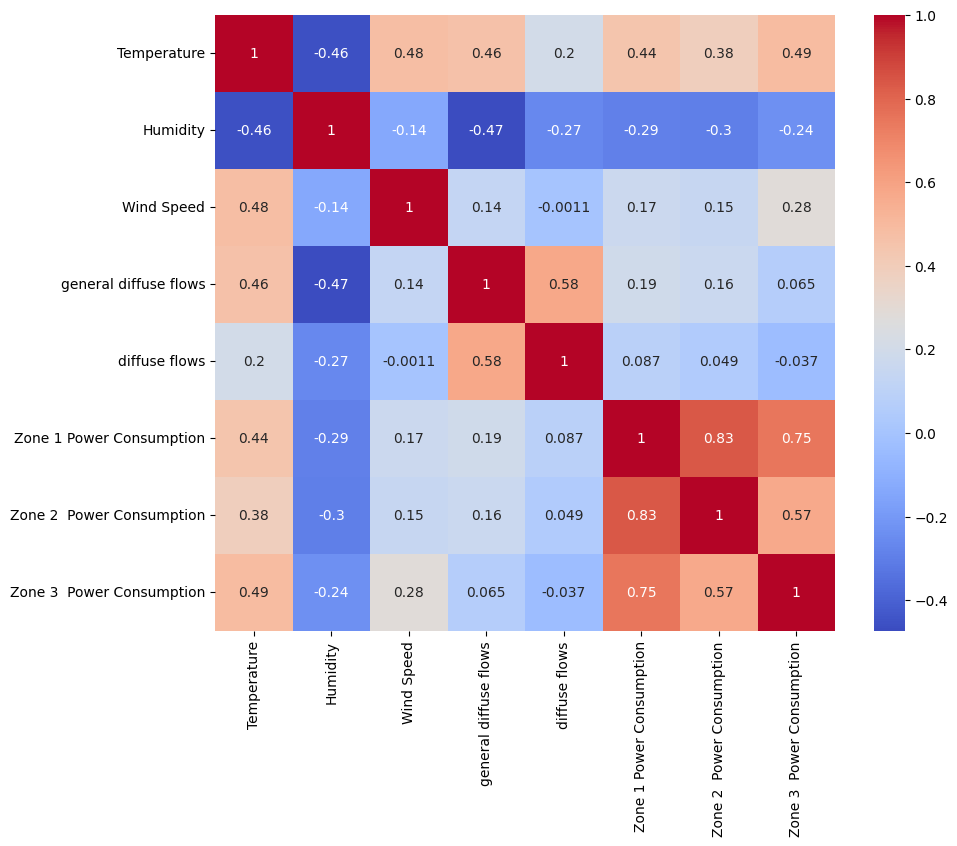

In [ ]:
# plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

We can make the following inferences from the correlation matrix:
- `Temperature`, `Wind Speed`, `general diffuse flows` are positively correlated to all the **power consumption zones**. Higher use of air conditioners could be a possible explanation for this.
- `Humidity` on the other hand, shows a slight negative correlation with the power consumption of all three areas.
- Power consumption in each of the three zones, show a **high correlation** between each other. This suggests that power consumption in these zones, tend to increase or decrease together.

## 2.1 Feature Creation

In [8]:
def create_features(df: pd.DataFrame):
    '''
    Function to create time series features from datetime index
    '''
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.weekofyear

    return df

In [9]:
# create features
df = create_features(df)
df.head(-5)

Temperature   Humidity  Wind Speed  \
DateTime                                                  
2017-01-01 00:00:00     6.196833  75.066667    0.081833   
2017-01-01 01:00:00     5.548833  77.583333    0.082000   
2017-01-01 02:00:00     5.054333  78.933333    0.082333   
2017-01-01 03:00:00     5.004333  77.083333    0.082833   
2017-01-01 04:00:00     5.097667  74.050000    0.082333   
...                          ...        ...         ...   
2017-12-30 14:00:00    14.565000  38.140000    0.077833   
2017-12-30 15:00:00    14.461667  41.245000    0.077500   
2017-12-30 16:00:00    14.255000  41.560000    0.077167   
2017-12-30 17:00:00    13.775000  44.448333    0.077833   
2017-12-30 18:00:00    10.771667  58.323333    0.076500   

                     general diffuse flows  diffuse flows  \
DateTime                                                    
2017-01-01 00:00:00               0.063500       0.098833   
2017-01-01 01:00:00               0.056833       0.112500   
2017-01-01 02:00:00               0.063000       0.129167   
2017-01-01 03:00:00               0.059833       0.141000   
2017-01-01 04:00:00               0.058000       0.122833   
...                                    ...            ...   
2017-12-30 14:00:00             456.550000      38.210000   
2017-12-30 15:00:00             362.750000      46.116667   
2017-12-30 16:00:00             226.316667     201.666667   
2017-12-30 17:00:00              81.493333     103.070000   
2017-12-30 18:00:00               3.185833       3.251500   

                     Zone 1 Power Consumption  Zone 2  Power Consumption  \
DateTime                                                                   
2017-01-01 00:00:00              29197.974683               18026.747720   
2017-01-01 01:00:00              24657.215190               16078.419453   
2017-01-01 02:00:00              22083.037973               14330.699088   
2017-01-01 03:00:00              20811.139240               13219.452887   
2017-01-01 04:00:00              20475.949367               12921.580547   
...                                       ...                        ...   
2017-12-30 14:00:00              29815.969578               26180.423440   
2017-12-30 15:00:00              28771.609633               25654.495243   
2017-12-30 16:00:00              28546.514577               25164.160785   
2017-12-30 17:00:00              33979.214195               29879.717705   
2017-12-30 18:00:00              37929.531053               32764.651735   

                     Zone 3  Power Consumption  hour  dayofweek  quarter  \
DateTime                                                                   
2017-01-01 00:00:00               19252.048193     0          6        1   
2017-01-01 01:00:00               17042.891567     1          6        1   
2017-01-01 02:00:00               15676.144578     2          6        1   
2017-01-01 03:00:00               14883.855422     3          6        1   
2017-01-01 04:00:00               14317.108433     4          6        1   
...                                        ...   ...        ...      ...   
2017-12-30 14:00:00               10597.839137    14          5        4   
2017-12-30 15:00:00               10424.009605    15          5        4   
2017-12-30 16:00:00               10592.076832    16          5        4   
2017-12-30 17:00:00               15039.615845    17          5        4   
2017-12-30 18:00:00               16786.554622    18          5        4   

                     month  year  dayofyear  dayofmonth  weekofyear  
DateTime                                                             
2017-01-01 00:00:00      1  2017          1           1          52  
2017-01-01 01:00:00      1  2017          1           1          52  
2017-01-01 02:00:00      1  2017          1           1          52  
2017-01-01 03:00:00      1  2017          1           1          52  
2017-01-01 04:00:00      1  2017          1           1      

In [ ]:
# print the columns
df.columns

Index(['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows',
       'diffuse flows', 'Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption', 'hour',
       'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth',
       'weekofyear'],
      dtype='object')

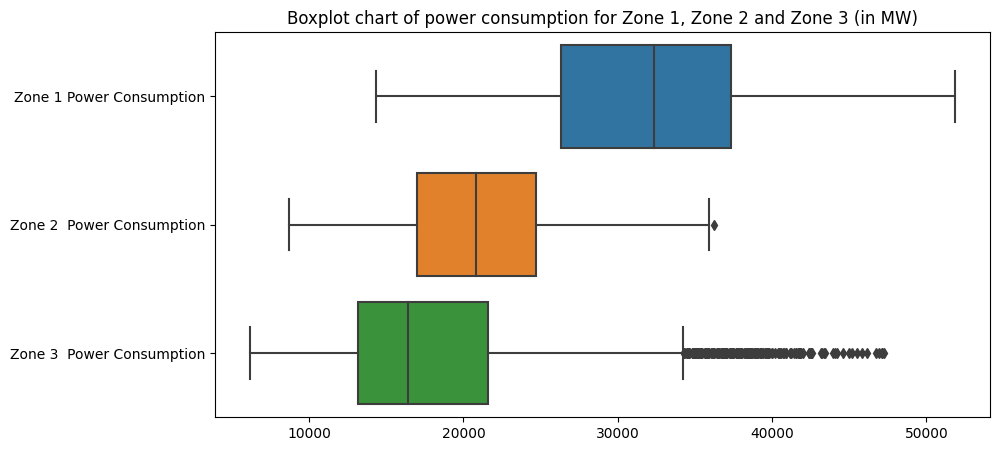

In [ ]:
# boxplot chart of power consumption for Zone 1, Zone 2 and Zone 3 (in KW)
plt.figure(figsize=(10, 5))
sns.boxplot(data=df[['Zone 1 Power Consumption',
       'Zone 2  Power Consumption', 'Zone 3  Power Consumption']], orient='h')
plt.title('Boxplot chart of power consumption for Zone 1, Zone 2 and Zone 3 (in MW)')
plt.show()

Based on the above boxplot, we can conclude that **Zone 1** has the highest power consumption, while **Zone 3** has the least.

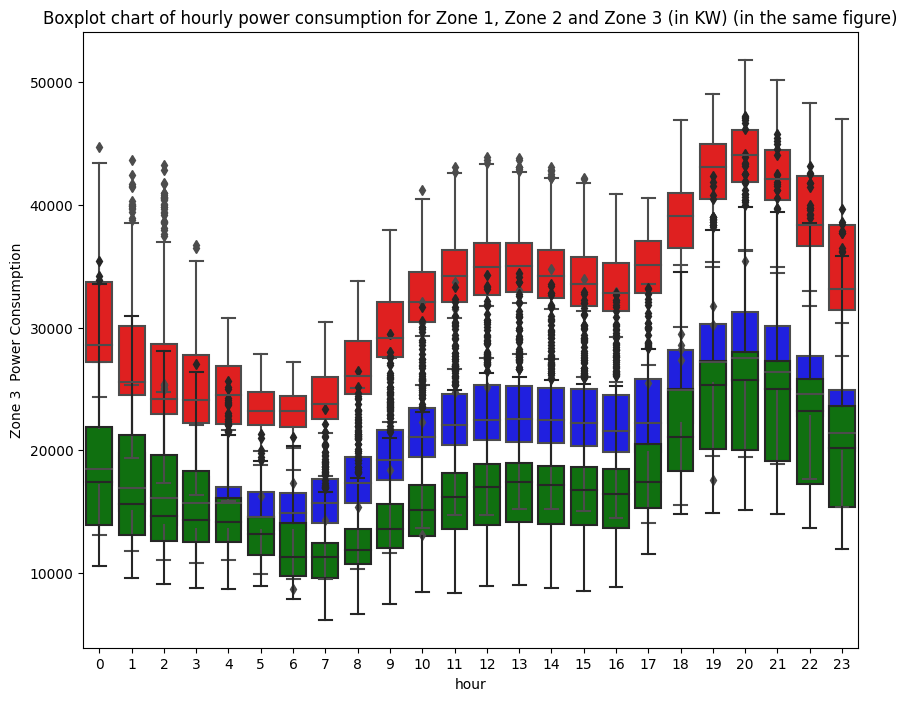

In [ ]:
# draw boxplot chart of hourly power consumption for Zone 1, Zone 2 and Zone 3 (in KW)
plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='Zone 1 Power Consumption', color='red')
sns.boxplot(data=df, x='hour', y='Zone 2  Power Consumption', color='blue')
sns.boxplot(data=df, x='hour', y='Zone 3  Power Consumption', color='green')
plt.title('Boxplot chart of hourly power consumption for Zone 1, Zone 2 and Zone 3 (in KW) (in the same figure)')
plt.show()

Again, based on the above plot we can see how **Zone 1** has higher average consumption compared to **Zone 2** and **Zone 3**. On top of that, the average consumption increases during the **evening** hours for all the three areas.

This has a direct correlation with the hourly **temperature**. We can observe this below:

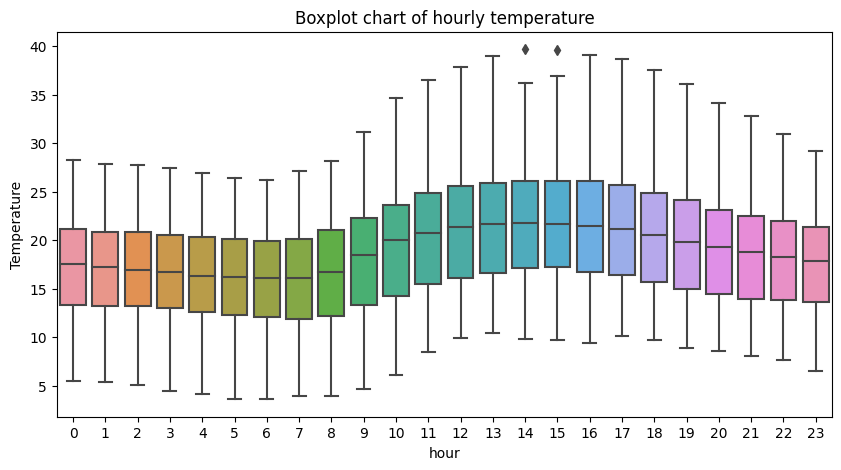

In [ ]:
# draw boxplot chart of hourly temperature
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='hour', y='Temperature')
plt.title('Boxplot chart of hourly temperature')
plt.show()

On the other hand, power consumption is **inversely correlated** with **humidity**. Hence, humidity follows the exact opposite trend.

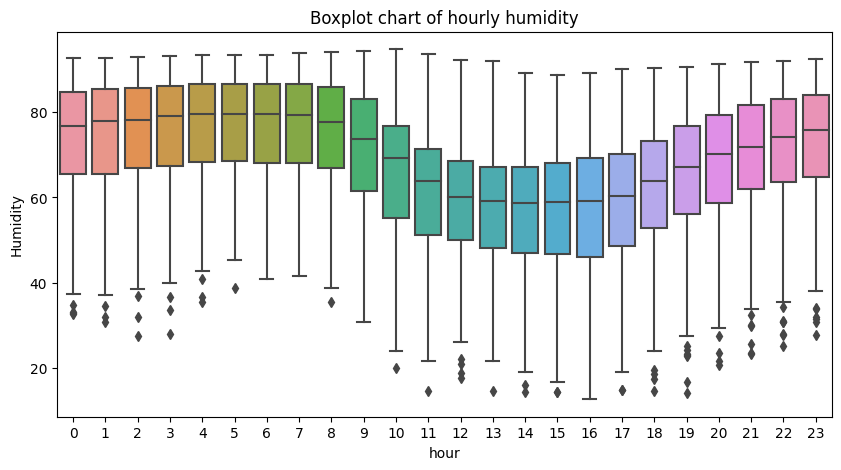

In [ ]:
# draw boxplot chart of hourly humidity
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='hour', y='Humidity')
plt.title('Boxplot chart of hourly humidity')
plt.show()

## 2.2 Creating the Target Column

In this problem, we will try to forecast the combined energy consumption of all the three zones together, i.e. we try to predict the sum of power consumed by Zone 1, 2 and 3 together.

We create the target column by summing the 3 columns.

In [10]:
# create target column: sum of power consumption for Zone 1, Zone 2 and Zone 3
df['Total Power Consumption'] = df['Zone 1 Power Consumption'] + df['Zone 2  Power Consumption'] + df['Zone 3  Power Consumption']

# 3. Pre-processing

Here, 70% of the data available is from **January 1st untill October 31st**, so that's going to be our **training set**. The remaining 30% of the data is from **November 1st untill December 30th**, which is our **test set**.

In [11]:
features = df.drop(['Zone 1 Power Consumption', 'Zone 2  Power Consumption', 'Zone 3  Power Consumption', 'Total Power Consumption'], axis=1)
target = df['Total Power Consumption']

In [12]:
target = df['Total Power Consumption']

We scale the `Total Power Consumption` column to parts per hundred thousand.

In [13]:
target = target/100000
target.describe()

count    8736.000000
mean        0.712229
std         0.170177
min         0.374076
25%         0.565854
50%         0.699050
75%         0.837816
max         1.331298
Name: Total Power Consumption, dtype: float64

In [14]:
# split the data into train and test sets
X_train = features.loc[features.index < '11-01-2017']
y_train = target.loc[target.index < '11-01-2017']
print('The shape of X_train is: ', X_train.shape)

X_test = features.loc[features.index >= '11-01-2017']
y_test = target.loc[target.index >= '11-01-2017']
print('The shape of X_test is: ', X_test.shape)

The shape of X_train is:  (7296, 13)
The shape of X_test is:  (1440, 13)


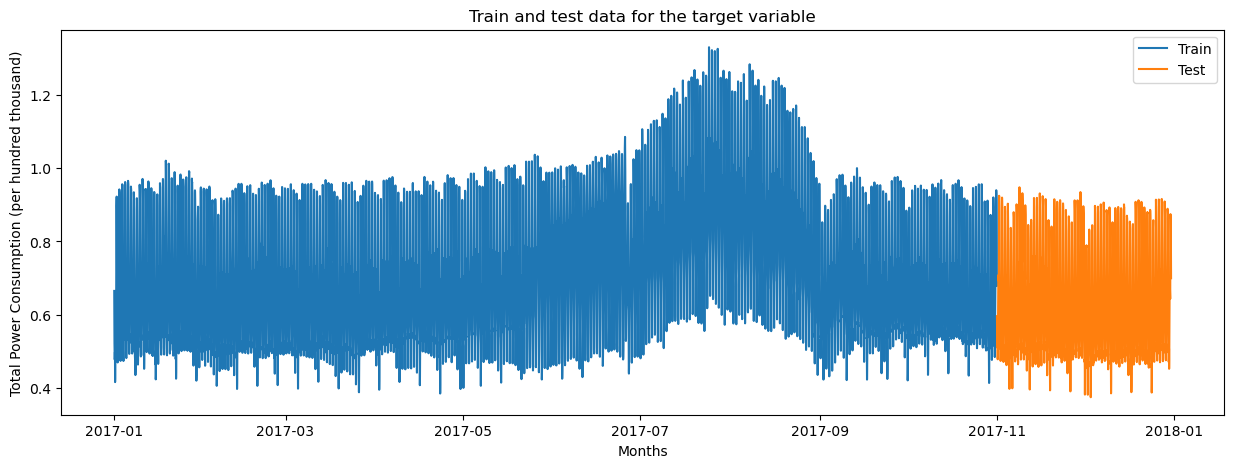

In [ ]:
# plot the train and test data for the target variable
plt.figure(figsize=(15, 5))
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.title('Train and test data for the target variable')
plt.ylabel('Total Power Consumption (per hundred thousand)')
plt.xlabel('Months')
plt.legend()
plt.show()

Based on this plot, the power consumption seems to follow the similar trend more or less throughout the year, with a discernable increase during the months of July, August and September.

## 3.1 Feature Importance

We calculate the **feature importance** of each of the features in the dataset, using the **Random Forest Regressor** algorithm.

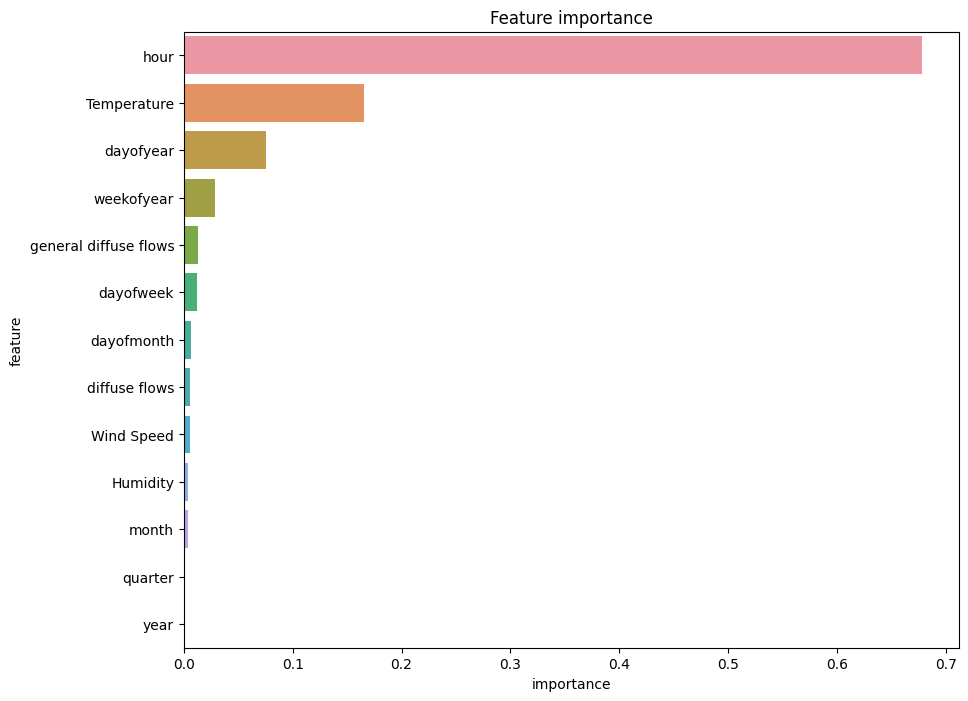

In [ ]:
# copy the training data
X_train_fs = X_train.copy()

# scale the data
scaler = StandardScaler()
X_train_fs_scaled = scaler.fit_transform(X_train_fs)

# instantiate the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# fit the model
rf.fit(X_train_fs_scaled, y_train)

# feature importance
feature_importance = pd.DataFrame({'feature': X_train_fs.columns, 'importance': rf.feature_importances_})

# plot the feature importance (sorted by feature importance)
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.sort_values(by='importance', ascending=False), x='importance', y='feature')
plt.title('Feature importance')
plt.show()

Based on the feature importance evidence above, we can conclude that the following features are the most important ones:
- `hour`
- `temperature`
- `dayofyear`
- `weekofyear`
- `general diffuse flows`
- `dayofweek`
- `dayofmonth`
- `Wind Speed`

In [15]:
# selecting the top features
top_features = ['hour', 'Temperature', 'dayofyear', 'weekofyear', 'general diffuse flows', 'dayofweek', 'dayofmonth', 'Wind Speed']

X_train = X_train[top_features]

X_test = X_test[top_features]

# scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Time Series Analysis

Firstly, we take a look at the data spanning over the first 2 months, to check the variation of the power consumption over a few months of data.

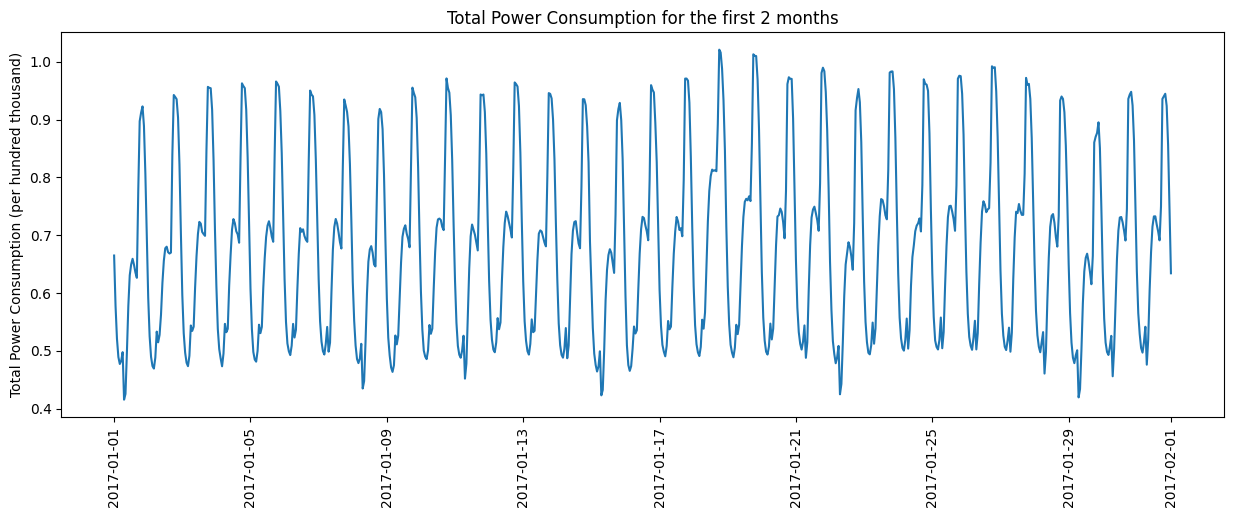

In [ ]:
# plot the data to observe power consumption for the first 2 months
plt.figure(figsize=(15, 5))
plt.plot(y_train.loc[y_train.index <= '02-01-2017'])
plt.xticks(rotation=90)
plt.title('Total Power Consumption for the first 2 months')
plt.ylabel('Total Power Consumption (per hundred thousand)')
plt.show()

This signifies the presence of seasonal component in the data. We zoom in further to see the variation of the power consumption over a week.

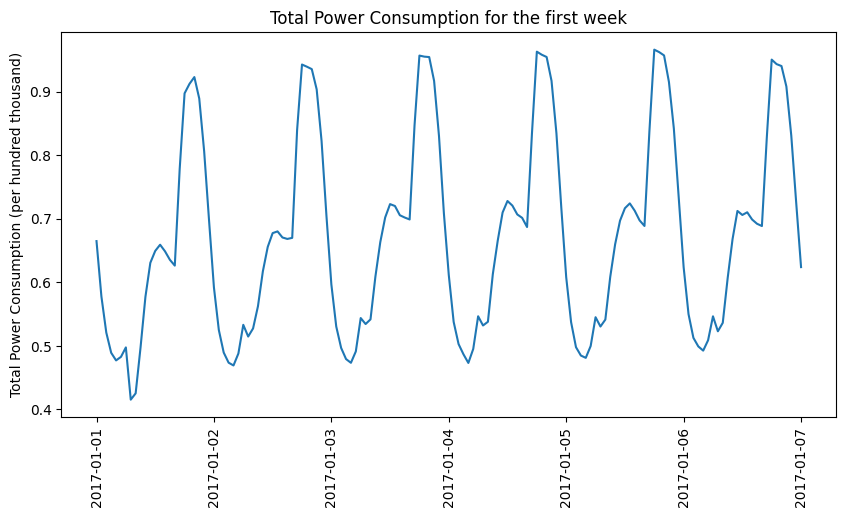

In [ ]:
# plot the data to observe power consumption for the first week
plt.figure(figsize=(10, 5))
plt.plot(y_train.loc[y_train.index <= '01-07-2017'])
plt.xticks(rotation=90)
plt.title('Total Power Consumption for the first week')
plt.ylabel('Total Power Consumption (per hundred thousand)')
plt.show()

This clearly shows the presence of **daily** seasonality in the data. Now, we zoom in even further to see the variation of the power consumption over a day, to pin down on possible hourly patterns.

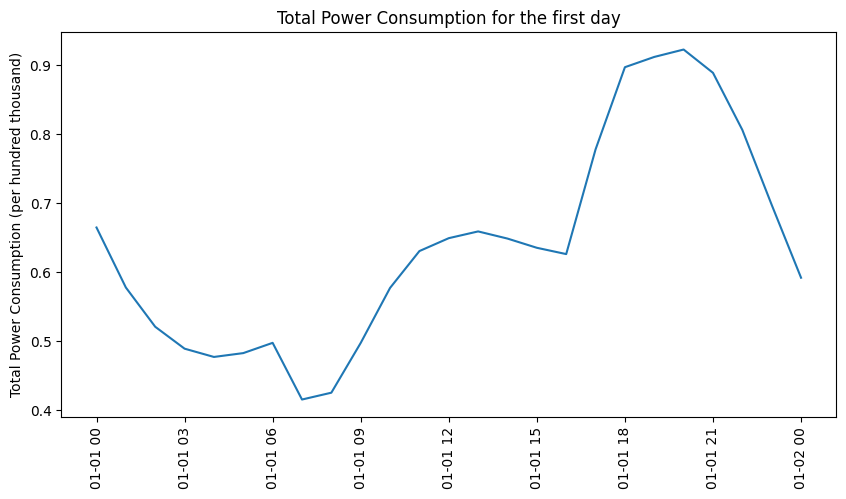

In [ ]:
# plot the data to observe power consumption for the first day
plt.figure(figsize=(10, 5))
plt.plot(y_train.loc[y_train.index <= '01-02-2017'])
plt.xticks(rotation=90)
plt.title('Total Power Consumption for the first day')
plt.ylabel('Total Power Consumption (per hundred thousand)')
plt.show()

Based on this plot, we can infer that the power consumption is maximum during the **evening hours**. This could be a direct result of the **temperature**. We can see this below:

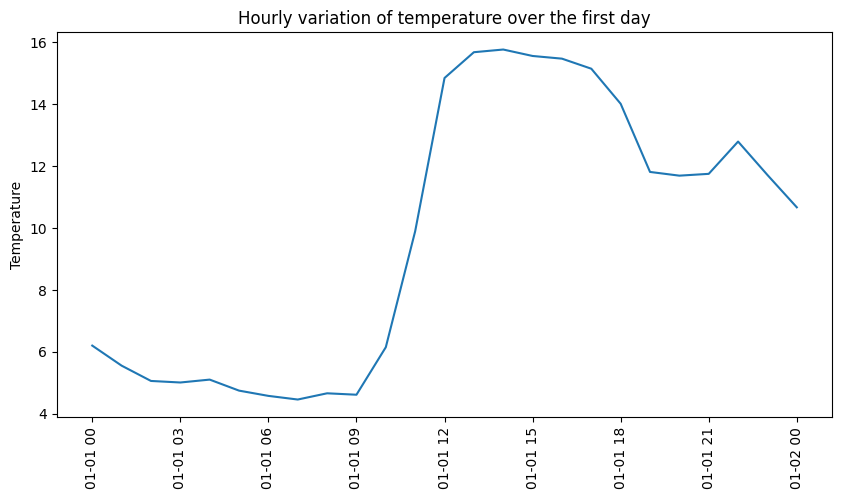

In [ ]:
# plot hourly variation of temperature over the first day
plt.figure(figsize=(10, 5))
plt.plot(X_train.loc[X_train.index <= '01-02-2017', 'Temperature'])
plt.xticks(rotation=90)
plt.title('Hourly variation of temperature over the first day')
plt.ylabel('Temperature')
plt.show()

## 4.1 Decomposition

In [16]:
# calculating the period: data is sampled every hour => 24 observations per day
period = 24

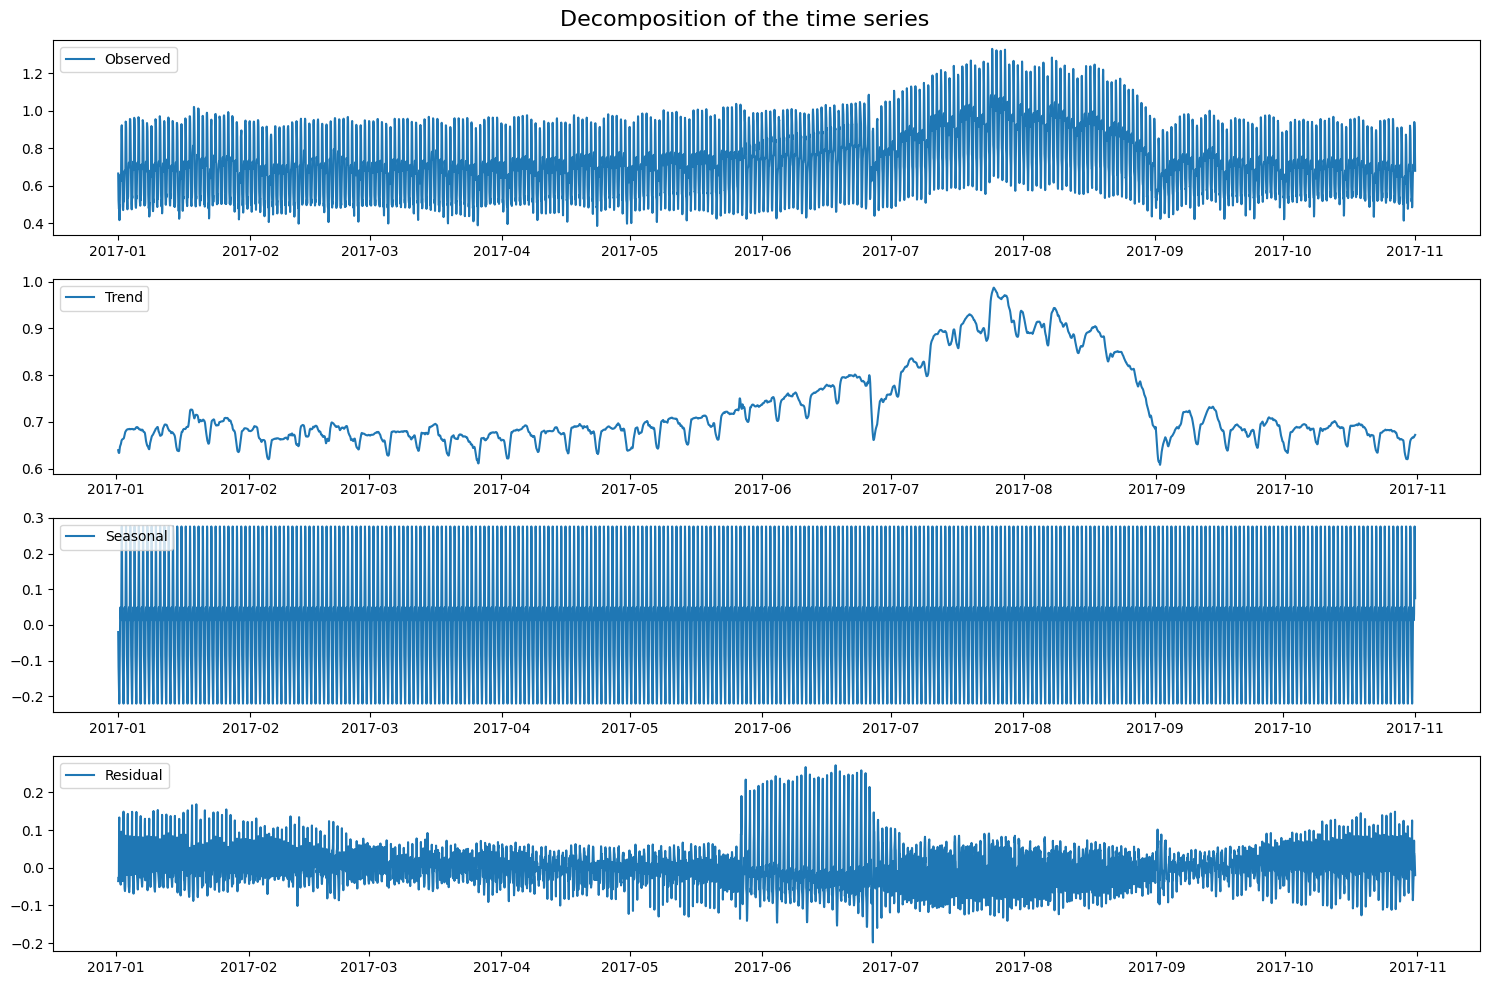

In [ ]:
# decompose the time series (additive model)
decomposition = seasonal_decompose(y_train, model='additive', period=period)

# plot the decomposition
plt.figure(figsize=(15, 10))
plt.suptitle('Decomposition of the time series', fontsize=16)

plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

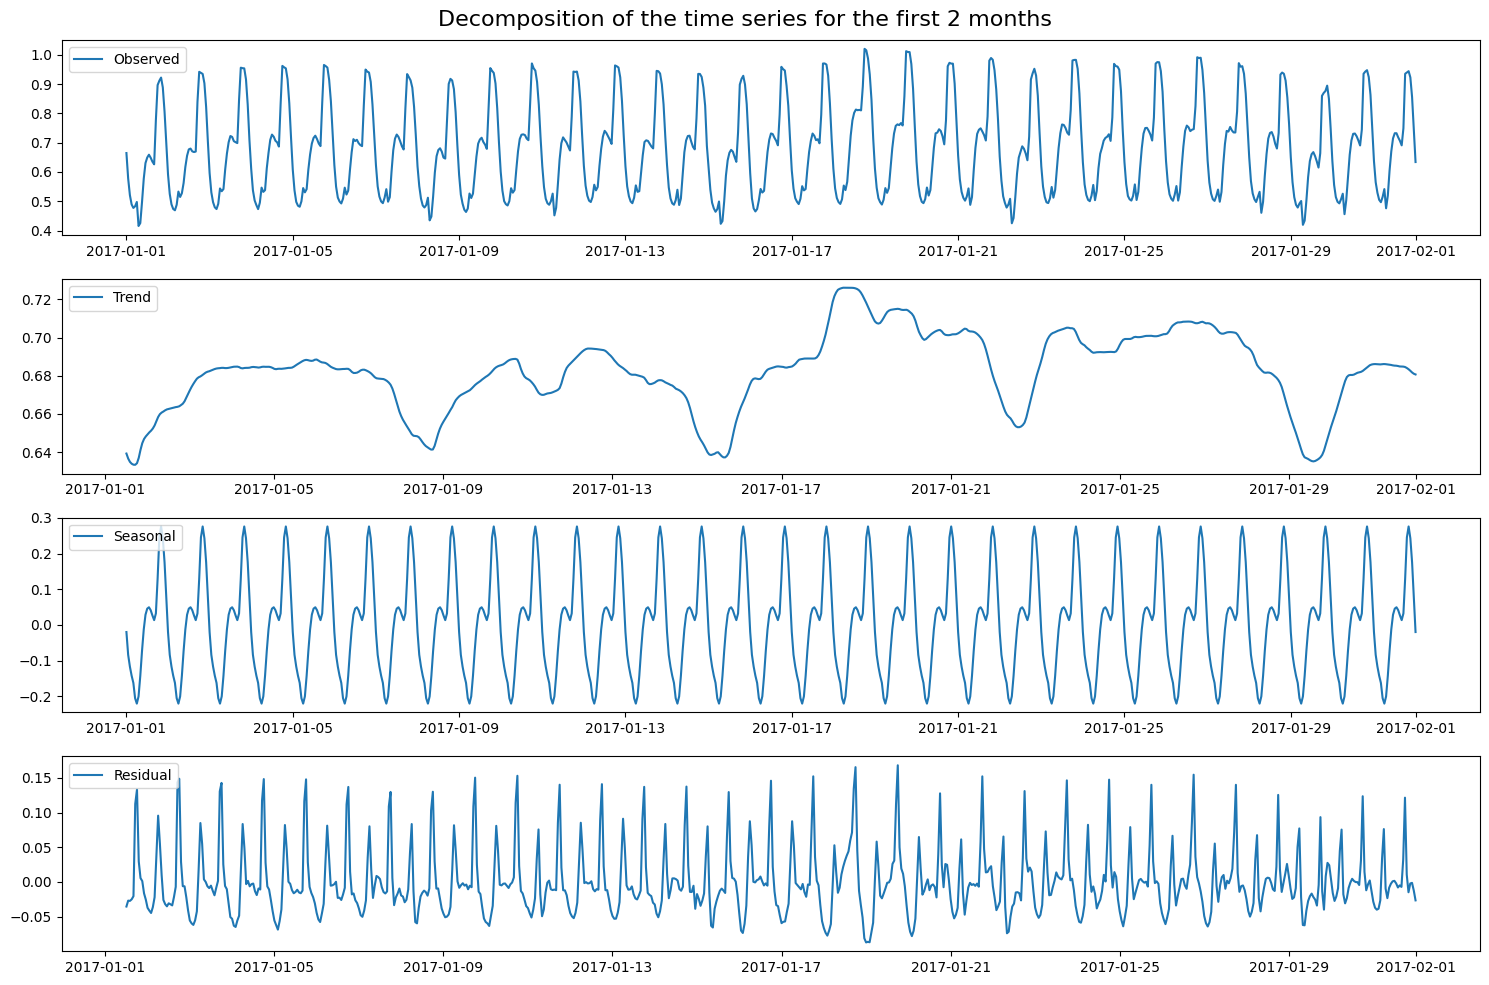

In [ ]:
# let's take a look at the components of the decomposition for the first 2 months

# plot the decomposition for the first 2 months
plt.figure(figsize=(15, 10))
plt.suptitle('Decomposition of the time series for the first 2 months', fontsize=16)

plt.subplot(411)
plt.plot(decomposition.observed.loc[decomposition.observed.index <= '02-01-2017'], label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend.loc[decomposition.trend.index <= '02-01-2017'], label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal.loc[decomposition.seasonal.index <= '02-01-2017'], label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid.loc[decomposition.resid.index <= '02-01-2017'], label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

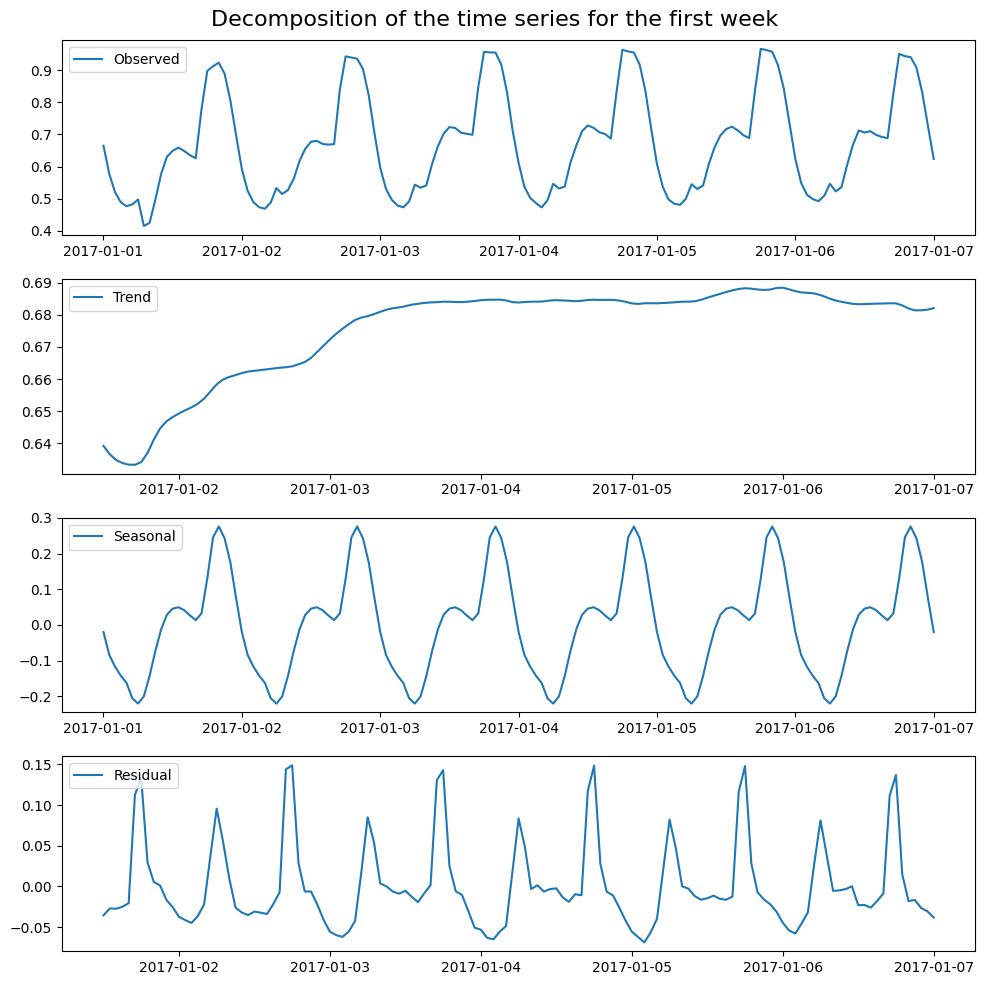

In [ ]:
# let's take a look at the components of the decomposition for the first week

# plot the decomposition for the first week
plt.figure(figsize=(10, 10))
plt.suptitle('Decomposition of the time series for the first week', fontsize=16)

plt.subplot(411)
plt.plot(decomposition.observed.loc[decomposition.observed.index <= '01-07-2017'], label='Observed')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(decomposition.trend.loc[decomposition.trend.index <= '01-07-2017'], label='Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(decomposition.seasonal.loc[decomposition.seasonal.index <= '01-07-2017'], label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(decomposition.resid.loc[decomposition.resid.index <= '01-07-2017'], label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## 4.2 Stationarity Check

We use **Augmented Dickey-Fuller** (ADF) test to check for stationarity in the data. The null hypothesis of the ADF test is that the time series is **non-stationary**. The test results comprise of a **test statistic** and some **critical values** for different confidence levels. For **p-values** less than `0.05`, we can reject the null hypothesis, i.e. the time series is **stationary**.

In [ ]:
# stationarity check using the ADF-test
print("ADF-test Observations (on Original Data):")
dftest = adfuller(y_train, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
print(dfoutput)

ADF-test Observations (on Original Data):

Test Statistic                   -2.416591

p-value                           0.137108

#Lags Used                       36.000000

Number of Observations Used    7259.000000

Critical Value (1%)              -3.431251

Critical Value (5%)              -2.861938

Critical Value (10%)             -2.566982

dtype: float64


Since, the **p-value** (`0.13`) is greater than `0.05` (significance level of `5%`), we fail to reject the null hypothesis and conclude that the time series is **non-stationary**.

In [ ]:
# stationarity check on first order differenced data using the ADF-test
print("ADF-test Observations: (on First Order Differenced Data)")
dftest = adfuller(y_train.diff().dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)' % key] = value
print(dfoutput)

ADF-test Observations: (on First Order Differenced Data)

Test Statistic                  -19.776232

p-value                           0.000000

#Lags Used                       36.000000

Number of Observations Used    7258.000000

Critical Value (1%)              -3.431251

Critical Value (5%)              -2.861938

Critical Value (10%)             -2.566982

dtype: float64


Since, the **p-value** (`0.0`) is smaller than `0.05` (significance level of `5%`), we reject the null hypothesis and conclude that the first order differenced time series is **stationary**.

## 4.3 Differencing

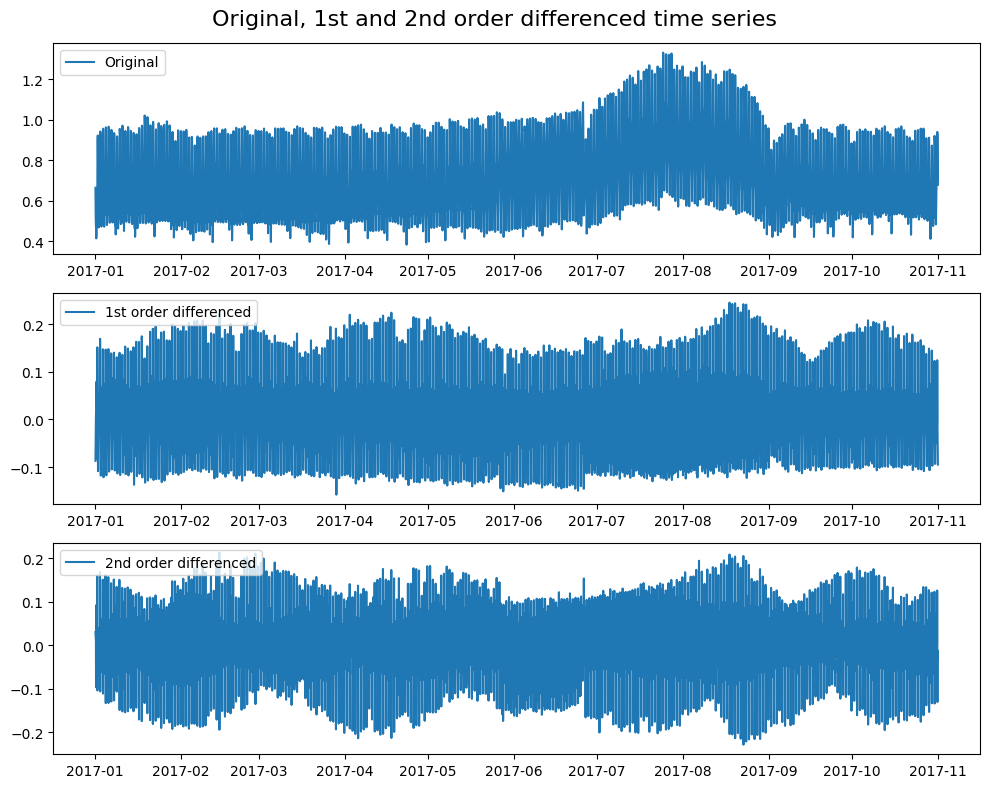

In [ ]:
# differencing the time series and comparing them
plt.figure(figsize=(10, 8))
plt.suptitle('Original, 1st and 2nd order differenced time series', fontsize=16)

# plot the original time series
plt.subplot(311)
plt.plot(y_train, label='Original')
plt.legend(loc='upper left')

# plot the 1st order differenced time series
plt.subplot(312)
plt.plot(y_train.diff().dropna(), label='1st order differenced')
plt.legend(loc='upper left')

# plot the 2nd order differenced time series
plt.subplot(313)
plt.plot(y_train.diff().diff().dropna(), label='2nd order differenced')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

## 4.4 ACF and PACF

Before trying to fit classical time series models like ARIMA, we need to find the optimal parameters for the model. 

We do this by plotting the **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** plots to find the optimal values of `p` and `q` for the first and second order difference data (as they are stationary based on ADF-Test).

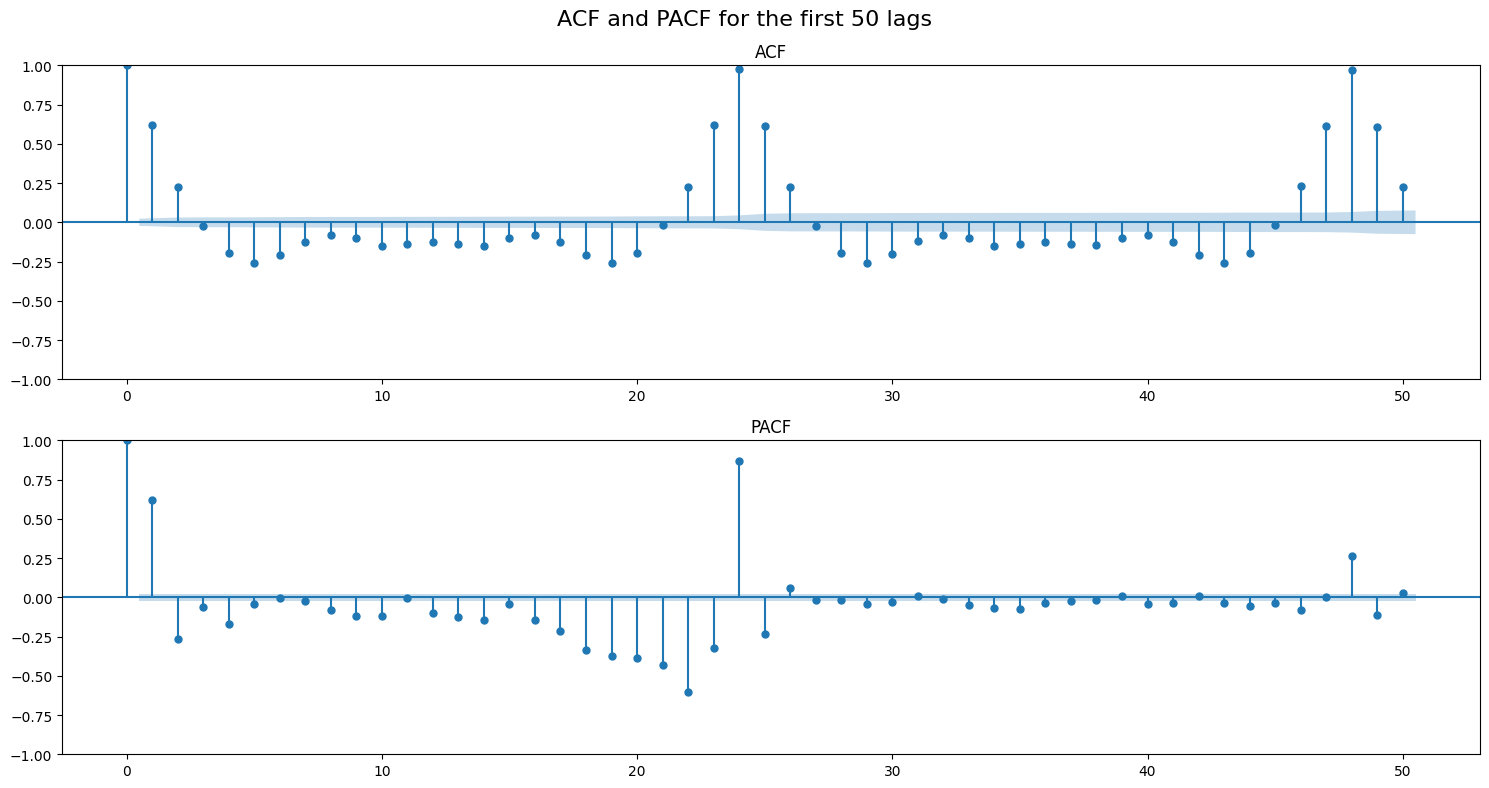

In [ ]:
# plot ACF and PACF for 1st order differenced time series
plt.figure(figsize=(15, 8))
plt.suptitle('ACF and PACF for the first 50 lags', fontsize=16)

# ACF
plt.subplot(211)
plot_acf(y_train.diff().dropna(), lags=50, ax=plt.gca(), title='ACF')

# PACF
plt.subplot(212)
plot_pacf(y_train.diff().dropna(), lags=50, ax=plt.gca(), title='PACF')

plt.tight_layout()
plt.show()

We observe sudden peaks near `lag = 24` and `lag = 24*2 = 48`. These peaks signify the presence of **daily** seasonality in the data.

Based on the `ACF` and `PACF` plots above we also decide upon the following parameters for the `ARIMA` model:
- `d = 1`: This represents the no. of differencing required to make the time series stationary.
- `q = 3`: This represents the no. of moving average terms in the series. After inspecting the `ACF` plot, we can see that the first 3 lags are significant, so we choose `q = 3`.
- `p = 3`: This represents the no. of autoregressive terms in the series. After inspecting the `PACF` plot, we can see that the first 3 lags are significant, so we choose `p = 3`.

So, we try fitting a `ARIMA(3, 1, 3)` model to the data.

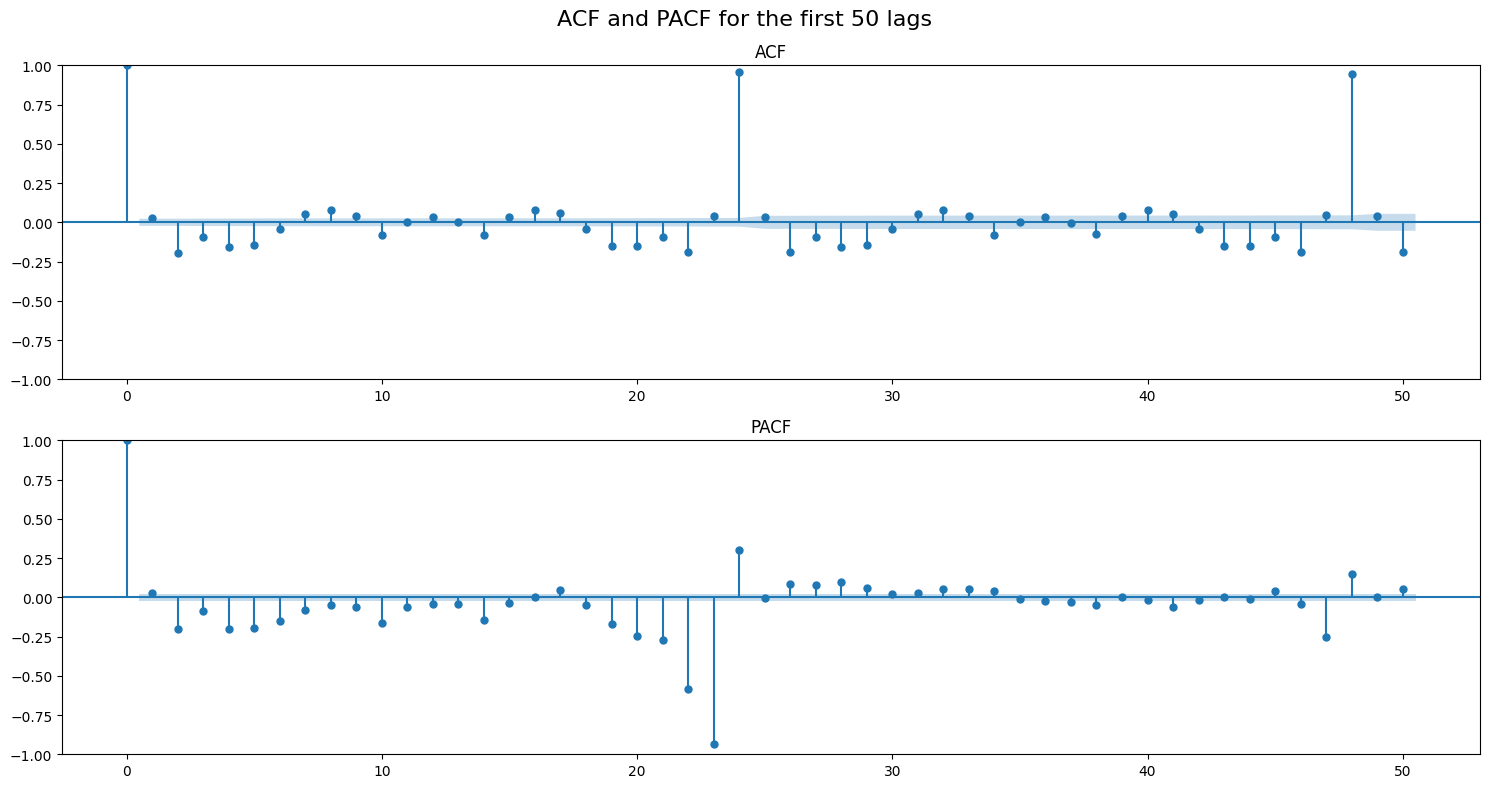

In [ ]:
# plot ACF and PACF for 2nd order differenced time series
plt.figure(figsize=(15, 8))
plt.suptitle('ACF and PACF for the first 50 lags', fontsize=16)

# ACF
plt.subplot(211)
plot_acf(y_train.diff().diff().dropna(), lags=50, ax=plt.gca(), title='ACF')

# PACF
plt.subplot(212)
plot_pacf(y_train.diff().diff().dropna(), lags=50, ax=plt.gca(), title='PACF')

plt.tight_layout()
plt.show()

As before, we again observe sudden peaks near `lag = 24` and `lag = 24*2 = 48`. These peaks signify the presence of **daily** seasonality in the data.

Again, based on the `ACF` and `PACF` plots above we decide upon the following parameters for the `ARIMA` model:
- `d = 2`: This represents the no. of differencing required to make the time series stationary.
- `q = 1`: This represents the no. of moving average terms in the series. After inspecting the `ACF` plot, we can see that the first lag is significant, so we choose `q = 1`.
- `p = 1`: This represents the no. of autoregressive terms in the series. After inspecting the `PACF` plot, we can see that the first lag is significant, so we choose `p = 1`.

So, we try fitting a `ARIMA(1, 2, 1)` model to the data.

## 4.5 ARIMA

### 4.5.1 ARIMA(3, 1, 3)

In [17]:
# fitting an ARIMA(p=3, d=1, q=3) model to the time series
model = ARIMA(y_train, order=(3, 1, 3))

# fit the model
model_fit = model.fit()

# print the summary of the model
print(model_fit.summary())

                                  SARIMAX Results                                  
Dep. Variable:     Total Power Consumption   No. Observations:                 7296
Model:                      ARIMA(3, 1, 3)   Log Likelihood               12256.230
Date:                     Thu, 20 Apr 2023   AIC                         -24498.459
Time:                             07:05:00   BIC                         -24450.195
Sample:                         01-01-2017   HQIC                        -24481.863
                              - 10-31-2017                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7939      0.115      6.924      0.000       0.569       1.019
ar.L2          0.4134      0.149      2.777      0.005       0.122       0.705
ar.L3       

- **Log Likelihood:** This is used to measure the goodness of fit of the model. The higher the value, the better the model. In this case the log-likelihood value is `12253.014`.

- **AIC:** This stands for **Akaike Information Criterion**. It is a measure of the relative quality of a statistical model for a given set of data. It balances the goodness of fit of the model (`MLE`) with the number of parameters used in the model, in order to prevent overfitting. In general, a model with a lower `AIC` score is considered to be a better fit for the data. The `AIC` is calculated as `AIC = 2k - 2ln(L)` where:
    - `k` is the number of parameters in the model.
    - `L` is the maximum value of the likelihood function for the model.
    - In this case the AIC value is `-24492.027`.

- **BIC:** This stands for **Bayesian Information Criterion**. It is a measure used to compare different models that have been fit to the same data. Like `AIC`, `BIC` is a way to balance the trade-off between model fit and model complexity, but it places a stronger penalty on models with more parameters. In general, the lower the `BIC` value, the better the model fits the data. The formula for `BIC` is similar to `AIC`, but it includes a penalty term for the number of parameters in the model. The `BIC` value is calculated as `BIC = -2 * LL + p * log(n)` where:
    - `p` is the number of parameters in the model.
    - `n` is the number of observations in the data set.
    - `LL` is the log-likelihood of the model.
    - Penalty term `p*log(n)` is larger in `BIC` than in `AIC`, so `BIC` is more strict in penalizing models with more parameters, i.e. it prefers simpler models.
    - In this case the BIC value is `-24443.763`.

- **HQIC:** This stands for **Hannan-Quinn Information Criterion**. It is another statistical criterion used for model selection, similar to `AIC` and `BIC`. `HQIC` is a modification of `AIC` that penalizes models for having additional parameters more heavily than `AIC` does. `HQIC` is defined as `HQIC = -2logL + 2k * log(log(T))` where:

    - `L` is the maximum value of the likelihood function for the model.
    - `k` is the number of model parameters.
    - `T` is the number of observations in the sample.
    - `HQIC` attempts to strike a balance between the complexity of the model and its ability to fit the data. A lower HQIC value indicates a better model fit.
    - In this case the `HQIC` value is `-24475.431`.

- **Covariance Type:** This refers to the type of covariance matrix used in the analysis. In this case, `opg` stands for **optimally weighted generalized least squares**.

- `coef`: These are the coefficients of the fitted model. For an `ARIMA(p,d,q)` model, there are `p+q+1` coefficients to estimate.

- `std err`: These are the standard errors associated with the coefficients. Standard errors are a measure of the uncertainty of the estimated coefficients. The lower the standard error, the more precise the estimate.

- `z`: These are the z-scores associated with the coefficients. The **z-score** is a measure of how many standard deviations away from zero the coefficient is. The higher the absolute value of the **z-score**, the more statistically significant the coefficient is (i.e. the more likely it is that the coefficient is not zero).

- `P>|z|`: This is the** p-value** associated with the **z-score**. It is used to test the **null hypothesis that the coefficient is equal to zero**. A **p-value less than 0.05 is typically considered statistically significant** (i.e. strong evidence against the null hypothesis, so we reject the null).

- `[0.025 0.975]`: These are the lower and upper bounds of the 95% confidence interval for the coefficient estimates.

- **Ljung-Box (L1) (Q):** This is a test for autocorrelation in the residuals of the model. In this case, Ljung-Box test was performed for lag 1 and the Q-statistic is `0.46`.

- **Jarque-Bera (JB):** This is a test for normality of the residuals of the model. In this case, the JB statistic is `8580.73`.

- **Prob(Q):** This is the p-value associated with the Ljung-Box test. A p-value less than 0.05 indicates that there is evidence of autocorrelation in the residuals. Here Prob(Q) is `0.50`, which is greater than 0.05, so we can conclude that there is no evidence of autocorrelation in the residuals.

- **Prob(JB):** This is the p-value associated with the Jarque-Bera test. A p-value less than `0.05` indicates that there is evidence of non-normality in the residuals.

- **Heteroskedasticity (H):** Heteroskedasticity refers to the unequal variances of the errors in a regression model. In the context of time series analysis, heteroskedasticity can occur when the variance of the errors changes over time. This can cause problems for forecasting, as it can make it difficult to accurately estimate the uncertainty of future predictions.In the output of an ARIMA model summary, the Heteroskedasticity (`H`) refers to a statistical test for the presence of heteroskedasticity. It is calculated as the ratio of the residual variance to the estimated variance under a homoskedasticity assumption. A value of `H` close to `1` indicates that there is no evidence of heteroskedasticity, while a value significantly different from `1` suggests that heteroskedasticity may be present.

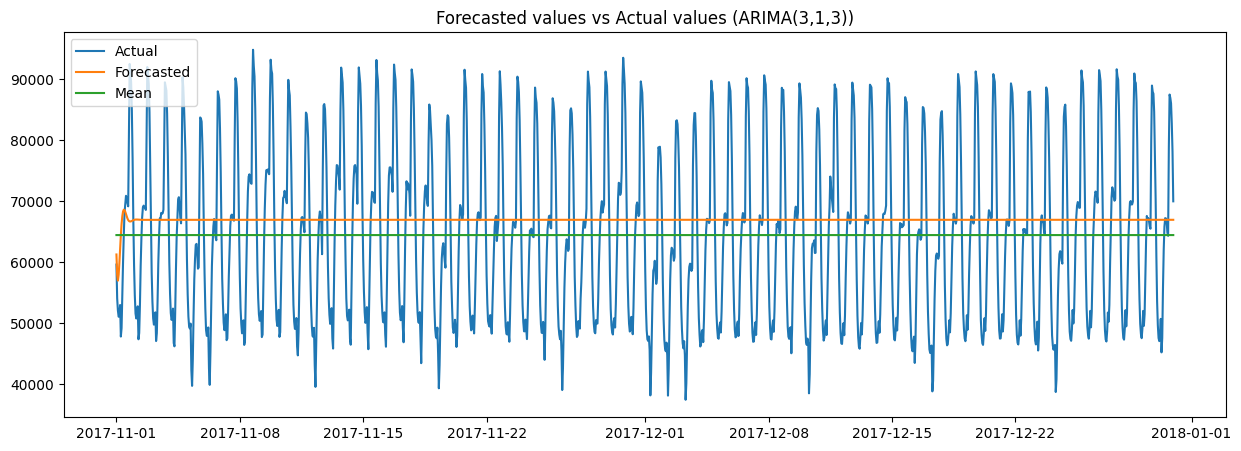

In [18]:
# forecast the next 2 months using the fitted model
forecast_ARIMA313 = model_fit.forecast(steps=y_test.shape[0])

# calculate the mean of the test data
y_test_mean = y_test.copy()
y_test_mean[:] = y_test.mean()

# plot the forecasted values against the actual values
plt.figure(figsize=(15, 5))
plt.plot(y_test*100000, label='Actual')
plt.plot(forecast_ARIMA313*100000, label='Forecasted')
plt.plot(y_test_mean*100000, label='Mean')
plt.title('Forecasted values vs Actual values (ARIMA(3,1,3))')
plt.legend(loc='upper left')

plt.show()

In [19]:
# calculate the mean squared error on the test data against the forecasted values by the ARIMA(3,1,3) model
mse_ARIMA313 = mean_squared_error(y_test*100000, forecast_ARIMA313*100000)
print('Mean Squared Error (ARIMA(3,1,3)): ', mse_ARIMA313)

Mean Squared Error (ARIMA(3,1,3)):  203960899.5371231


In [20]:
# calculate r2 score on the test data against the forecasted values
r2_ARIMA313 = r2_score(y_test*100000, forecast_ARIMA313*100000)
print('R2 Score (ARIMA(3,1,3)): ', r2_ARIMA313)

R2 Score (ARIMA(3,1,3)):  -0.028437389178159966


The observations seems more or less constant and close to the mean. We can also try forecasting again using **Teacher-Forcing** method, and try to see if the performance improves.

### 4.5.2 ARIMA(1, 2, 1)

In [21]:
# fitting an ARIMA(p=1, d=2, q=1) model to the time series
model = ARIMA(y_train, order=(1, 2, 1))

# fit the model
model_fit = model.fit()

# print the summary of the model
print(model_fit.summary())

                                  SARIMAX Results                                  
Dep. Variable:     Total Power Consumption   No. Observations:                 7296
Model:                      ARIMA(1, 2, 1)   Log Likelihood               11402.593
Date:                     Thu, 20 Apr 2023   AIC                         -22799.185
Time:                             07:07:08   BIC                         -22778.501
Sample:                         01-01-2017   HQIC                        -22792.072
                              - 10-31-2017                                         
Covariance Type:                       opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6232      0.011     58.209      0.000       0.602       0.644
ma.L1         -1.0000      0.210     -4.761      0.000      -1.412      -0.588
sigma2      

Based on the `AIC`, `BIC` and `HQIC`, we can conclude that the `ARIMA(1, 2, 1)` model performs worse than the `ARIMA(3, 1, 3)` model (because lower value is better). This is because the series after differencing twice becomes too noisy.

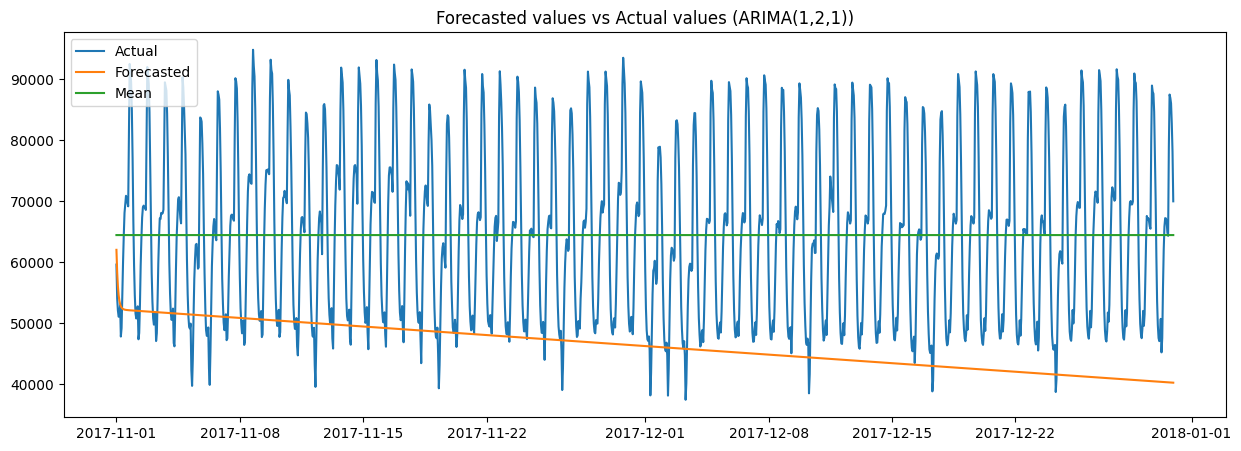

In [22]:
# forecast the next 2 months using the fitted model
forecast_ARIMA121 = model_fit.forecast(steps=y_test.shape[0])

# calculate the mean of the test data
y_test_mean = y_test.copy()
y_test_mean[:] = y_test.mean()

# plot the forecasted values against the actual values
plt.figure(figsize=(15, 5))
plt.plot(y_test*100000, label='Actual')
plt.plot(forecast_ARIMA121*100000, label='Forecasted')
plt.plot(y_test_mean*100000, label='Mean')
plt.title('Forecasted values vs Actual values (ARIMA(1,2,1))')
plt.legend(loc='upper left')

plt.show()

In [ ]:
# calculate the mean squared error on the test data against the forecasted values by the ARIMA(1,2,1) model
mse_ARIMA121 = mean_squared_error(y_test*100000, forecast_ARIMA121*100000)
print('Mean Squared Error (ARIMA(1,2,1)): ', mse_ARIMA121)

Mean Squared Error (ARIMA(1,2,1)):  539569276.5218918


In [23]:
# calculate r2 score on the test data against the forecasted values
r2_ARIMA121 = r2_score(y_test*100000, forecast_ARIMA121*100000)
print('R2 Score (ARIMA(1,2,1)): ', r2_ARIMA121)

R2 Score (ARIMA(1,2,1)):  -1.7242863796918404


This is reflected in the `MSE` as well, where `ARIMA(1, 2, 1)` has significantly higher `MSE` than `ARIMA(3, 1, 3)`.

# 5. Generating Sequences

We convert this time series data into a supervised learning problem by creating sequences of data. We use the `create_sequences` function to generate sequences of data.

In [ ]:
# some hyperparameters
n_weeks = 2
# we think that the power consumption pattern over 2 weeks may be better for inference
training_window_size = period*(n_weeks*7)
prediction_window_size = 1

In [ ]:
def create_sequences(X, y, training_window_size=training_window_size, prediction_window_size=prediction_window_size):
    '''
    Function to create sequences of data with a specified lag (training window size) and number of observations to forecast (prediction window size)

    Parameters:
    X: features
    y: target
    training_window_size: lag
    prediction_window_size: number of observations to forecast

    Returns:
    X_seq: array of features
    y_seq: array of target
    '''
    X_seq, y_seq = [], []

    for i in range(len(X) - training_window_size - prediction_window_size + 1):
        X_seq.append(X[i: i + training_window_size])
        y_seq.append(y[i + training_window_size: i + training_window_size + prediction_window_size])

    return np.array(X_seq), np.array(y_seq)

In [ ]:
# storing data in Dataset class

class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
# create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, training_window_size=training_window_size, prediction_window_size=prediction_window_size)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, training_window_size=training_window_size, prediction_window_size=prediction_window_size)

# checking the shape of the data
print('The shape of X_train_seq is: ', X_train_seq.shape)
print('The shape of y_train_seq is: ', y_train_seq.shape)
print('The shape of X_test_seq is: ', X_test_seq.shape)
print('The shape of y_test_seq is: ', y_test_seq.shape)

The shape of X_train_seq is:  (6960, 336, 8)
The shape of y_train_seq is:  (6960, 1)
The shape of X_test_seq is:  (1104, 336, 8)
The shape of y_test_seq is:  (1104, 1)


In [ ]:
# extract input and output size
input_size = X_train_seq.shape[2]
output_size = y_train_seq.shape[1]

# print the input and output size
print('The input size is: ', input_size)
print('The output size is: ', output_size)

The input size is:  8
The output size is:  1


In [ ]:
# create the dataset
train_dataset = SequenceDataset(X_train_seq, y_train_seq)
test_dataset = SequenceDataset(X_test_seq, y_test_seq)

# set the batch size
batch_size = 128

# create the data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=y_test_seq.shape[0], shuffle=False)

# checking the length of the data loader
print('The length of train_loader is: ', len(train_loader))
print('The length of test_loader is: ', len(test_loader))

The length of train_loader is:  55
The length of test_loader is:  1


# 5. Neural Networks

In [ ]:
# define a helper function to calculate the mean squared error on the test data against the forecasted values by the model, and plot the forecasted values against the actual values for the test data for all the models in the list.

def evaluate_nn_mse(model, test_loader ,model_state_dict_paths, device):
    '''
    This function evaluates the mean squared error on the test data against the forecasted values by the model, and plots the forecasted values against the actual values for the test data for all the models in the list.

    Parameters:
    - model: the model to be evaluated
    - test_loader: the test data loader
    - model_state_dict_paths: list of paths to the model state dictionaries
    - device: the device to be used

    Returns: None
    '''
    # add model to device
    model.to(device)

    # initialize list to store the mean squared errors
    mse_list = []

    # create a list of model names
    model_names = [model_save_path.split('/')[-1].split('.')[0] for model_save_path in model_state_dict_paths]

    # plot the forecasted values against the actual values on the test data for all the models in the list
    plt.figure(figsize=(15, 4*len(model_names)))
    plt.suptitle('Forecasted values vs Actual values')

    for i, model_save_path in enumerate(model_state_dict_paths):
        # load the model state dictionary
        model.load_state_dict(torch.load(model_save_path))

        # set the model to evaluation mode
        model.eval()

        for (features, targets) in test_loader:
            features = features.float().to(device)
            targets = targets.float().to(device)

            # forecast on the test data using the model
            with torch.no_grad():
                outputs = model(features)
            
            # plot the forecasted values against the actual values
            plt.subplot(len(model_names), 1, i+1)
            plt.plot(targets.cpu().numpy()*100000, label='Actual')
            plt.plot(outputs.cpu().numpy()*100000, label='Forecasted')
            plt.title(model_names[i])
            plt.legend(loc='upper left')
            
            # calculate the mean squared error on the test data against the forecasted values by the model
            mse_model = mean_squared_error(targets.cpu().numpy()*100000, outputs.cpu().numpy()*100000)

            # append the mean squared error to the list
            mse_list.append(mse_model)
    
    plt.tight_layout()
    plt.show()

    # print the mean squared errors against the model names
    for model_name, mse in zip(model_names, mse_list):
        print(model_name, mse)

    # print the mean squared errors against the model names
    plt.figure(figsize=(15, 4))
    plt.bar(model_names, mse_list)
    plt.title('Mean Squared Error')
    plt.show()


## 5.1 LSTM

In [ ]:
# LSTM architecture

class LSTM(nn.Module):

    def __init__(self, input_size=input_size, hidden_size=128, num_layers=2, output_size=output_size):
        '''
        Parameters:
        input_size: number of features, default is input_size
        hidden_size: number of hidden units, default is 128
        num_layers: number of LSTM layers, default is 2
        output_size: number of output units, default is 1
        '''
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        '''
        Parameters:
        x: input data, dimensions: (batch_size, sequence_length, input_size)

        Returns:
        out: output of the model, dimensions: (batch_size, output_size)
        '''
        # set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        # out: tensor of shape (batch_size, seq_length, hidden_size)
        # we only need the output at the last time step
        # out[:, -1, :]: tensor of shape (batch_size, hidden_size)
        out = self.fc(out[:, -1, :])
        # out: tensor of shape (batch_size, output_size)
        return out

In [ ]:
# instantiate the model
model = LSTM().to(device)

# define the loss function
criterion = nn.MSELoss()

# define the hyperparameters
num_epochs = 300
learning_rate = 0.001

print_step = 10

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# store the training loss
train_loss = []

# training the model
for epoch in tqdm(range(num_epochs)):
    # set the model to training mode
    model.train()

    # set epoch loss to 0
    epoch_loss = 0

    # iterate over the data
    for (features, targets) in train_loader:
        features = features.float().to(device)
        targets = targets.float().to(device)

        # forward pass
        outputs = model(features)
        loss = criterion(outputs, targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update the epoch loss
        epoch_loss += loss.item()
    
    # store the mean epoch loss
    train_loss.append(epoch_loss / len(train_loader))

    # print training information every `print_step` epochs
    if (epoch + 1) % print_step == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.8f}')
        
    # save the model
    if (epoch + 1) % 50 == 0:
        print("\nSaving Model...\n")
        model_save_path = '/kaggle/working/lstm_' +  str(epoch+1) + '.pt'
        torch.save(model.state_dict(), model_save_path)

  3%|▎         | 10/300 [00:25<12:26,  2.57s/it]

Epoch [10/300], Loss: 0.00235156


  7%|▋         | 20/300 [00:51<11:58,  2.57s/it]

Epoch [20/300], Loss: 0.00068257


 10%|█         | 30/300 [01:17<11:34,  2.57s/it]

Epoch [30/300], Loss: 0.00047628


 13%|█▎        | 40/300 [01:42<11:10,  2.58s/it]

Epoch [40/300], Loss: 0.00034168


 17%|█▋        | 50/300 [02:08<10:45,  2.58s/it]

Epoch [50/300], Loss: 0.00029648

Saving Model...



 20%|██        | 60/300 [02:34<10:20,  2.58s/it]

Epoch [60/300], Loss: 0.00029382


 23%|██▎       | 70/300 [03:00<09:52,  2.58s/it]

Epoch [70/300], Loss: 0.00023548


 27%|██▋       | 80/300 [03:26<09:27,  2.58s/it]

Epoch [80/300], Loss: 0.00067713


 30%|███       | 90/300 [03:51<09:02,  2.58s/it]

Epoch [90/300], Loss: 0.00022655


 33%|███▎      | 100/300 [04:17<08:36,  2.58s/it]

Epoch [100/300], Loss: 0.00016733

Saving Model...



 37%|███▋      | 110/300 [04:43<08:09,  2.58s/it]

Epoch [110/300], Loss: 0.00015983


 40%|████      | 120/300 [05:09<07:42,  2.57s/it]

Epoch [120/300], Loss: 0.00013799


 43%|████▎     | 130/300 [05:34<07:17,  2.57s/it]

Epoch [130/300], Loss: 0.00013211


 47%|████▋     | 140/300 [06:00<06:52,  2.58s/it]

Epoch [140/300], Loss: 0.00013836


 50%|█████     | 150/300 [06:26<06:27,  2.58s/it]

Epoch [150/300], Loss: 0.00012755

Saving Model...



 53%|█████▎    | 160/300 [06:52<06:01,  2.58s/it]

Epoch [160/300], Loss: 0.00015731


 57%|█████▋    | 170/300 [07:18<05:36,  2.59s/it]

Epoch [170/300], Loss: 0.00009291


 60%|██████    | 180/300 [07:43<05:08,  2.57s/it]

Epoch [180/300], Loss: 0.00006815


 63%|██████▎   | 190/300 [08:09<04:42,  2.57s/it]

Epoch [190/300], Loss: 0.00007829


 67%|██████▋   | 200/300 [08:35<04:17,  2.58s/it]

Epoch [200/300], Loss: 0.00006995

Saving Model...



 70%|███████   | 210/300 [09:01<03:52,  2.58s/it]

Epoch [210/300], Loss: 0.00006183


 73%|███████▎  | 220/300 [09:26<03:25,  2.57s/it]

Epoch [220/300], Loss: 0.00005755


 77%|███████▋  | 230/300 [09:52<03:00,  2.57s/it]

Epoch [230/300], Loss: 0.00005105


 80%|████████  | 240/300 [10:18<02:34,  2.57s/it]

Epoch [240/300], Loss: 0.00007001


 83%|████████▎ | 250/300 [10:43<02:08,  2.58s/it]

Epoch [250/300], Loss: 0.00005332

Saving Model...



 87%|████████▋ | 260/300 [11:09<01:42,  2.57s/it]

Epoch [260/300], Loss: 0.00004971


 90%|█████████ | 270/300 [11:35<01:17,  2.57s/it]

Epoch [270/300], Loss: 0.00004946


 93%|█████████▎| 280/300 [12:01<00:51,  2.57s/it]

Epoch [280/300], Loss: 0.00003404


 97%|█████████▋| 290/300 [12:26<00:25,  2.57s/it]

Epoch [290/300], Loss: 0.00003738


100%|██████████| 300/300 [12:52<00:00,  2.57s/it]

Epoch [300/300], Loss: 0.00005248

Saving Model...



In [ ]:
model_state_dict_paths = [os.path.join('/content/drive/MyDrive/models', 'lstm_50.pt'),
                         os.path.join('/content/drive/MyDrive/models', 'lstm_100.pt'),
                         os.path.join('/content/drive/MyDrive/models', 'lstm_150.pt'),
                         os.path.join('/content/drive/MyDrive/models', 'lstm_200.pt'),
                         os.path.join('/content/drive/MyDrive/models', 'lstm_250.pt'),
                         os.path.join('/content/drive/MyDrive/models', 'lstm_300.pt')]

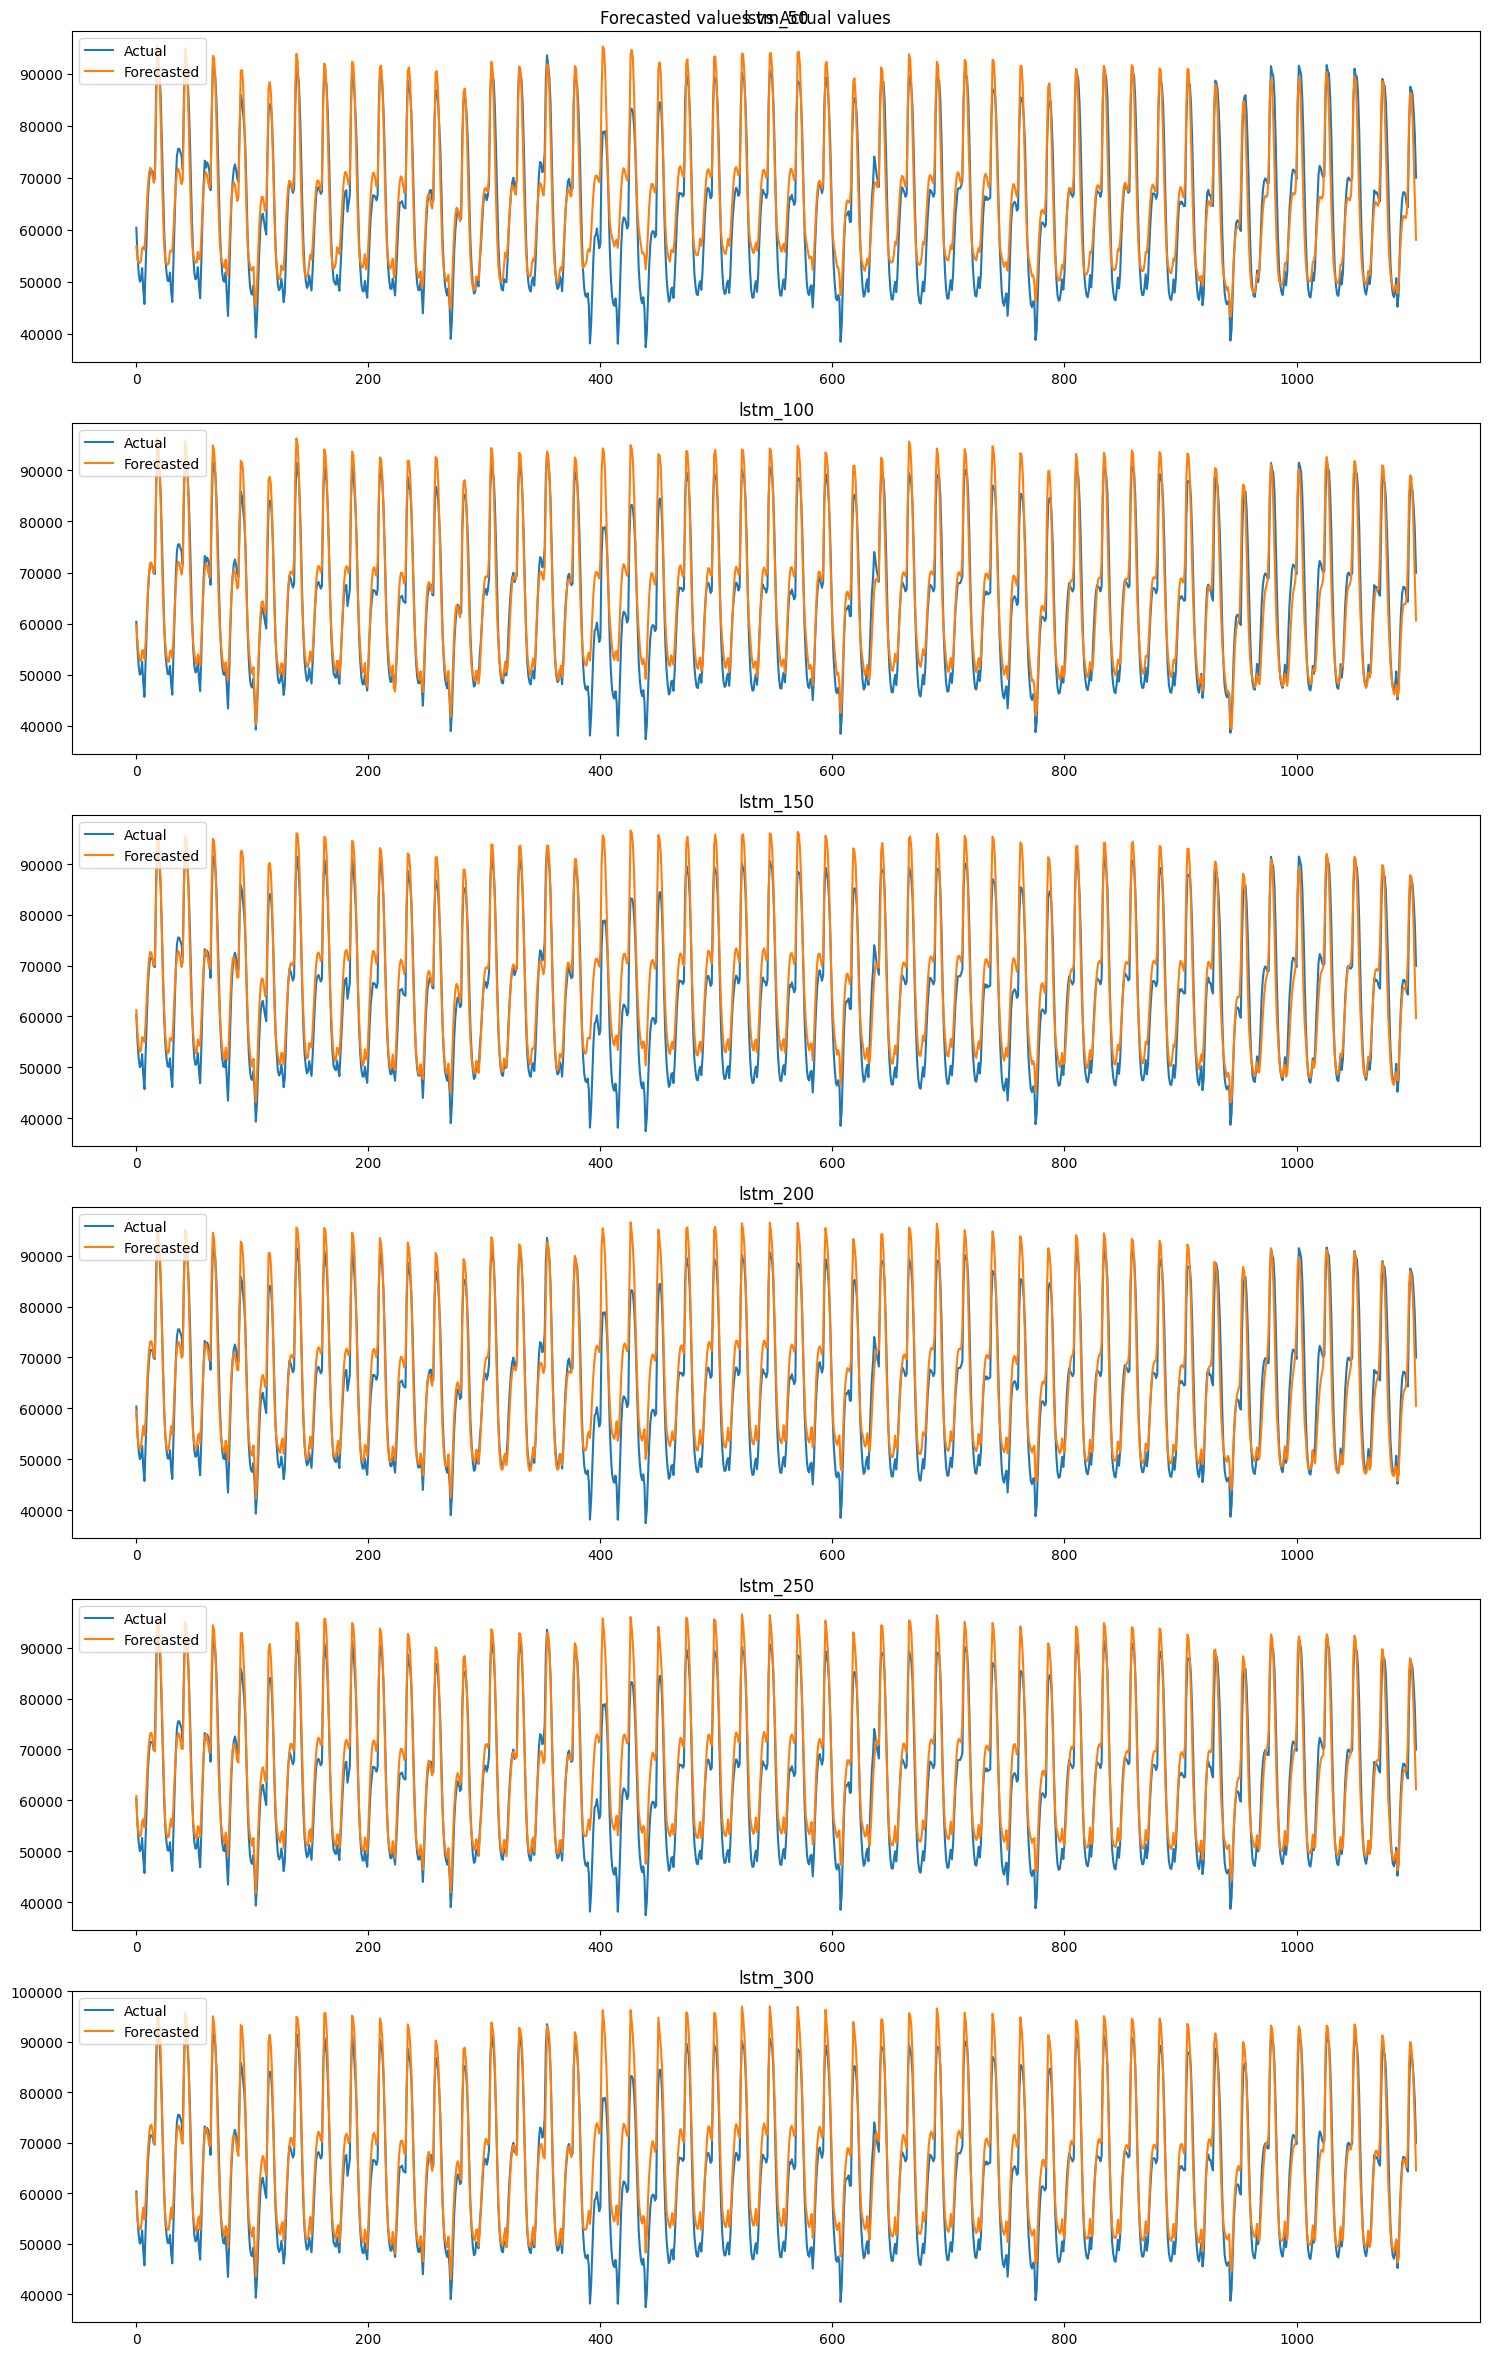

lstm_50 25312742.688257962
lstm_100 17565033.417357348
lstm_150 23539559.357771877
lstm_200 21604875.971095655
lstm_250 19379508.371046092
lstm_300 20168243.64853882


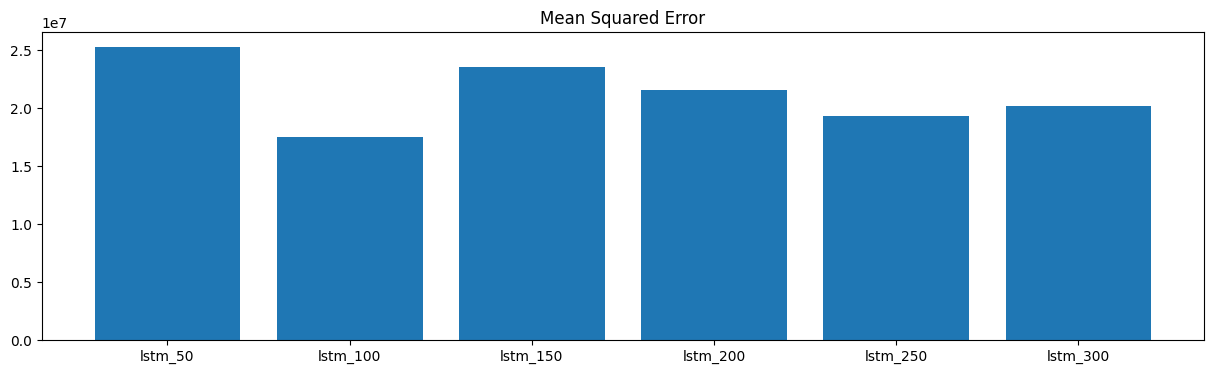

In [ ]:
# evaluate the model
model = LSTM()

evaluate_nn_mse(model, test_loader, model_state_dict_paths, device)

## 5.2 Transformer

In [ ]:
# Transformer architecture

class Transformer(nn.Module):
    def __init__(self, input_size=input_size, input_seq_size=training_window_size, output_seq_size=1, encoder_embedding_size=32, decoder_embedding_size=16, num_encoder_heads=4, num_decoder_heads=1, num_encoder_layers=2, num_decoder_layers=1):
        '''
        Caution: Make sure encoder_embedding_size is divisible by num_encoder_heads and decoder_embedding_size is divisible by num_decoder_heads.
        
        Parameters:
        input_size: number of features, default is input_size
        input_seq_size: number of input units, default is training_window_size
        output_seq_size: number of output units, default is 1
        encoder_embedding_size: embedding size of the encoder, default is 32
        decoder_embedding_size: embedding size of the decoder, default is 16
        num_encoder_heads: number of attention heads in the encoder, default is 4
        num_decoder_heads: number of attention heads in the decoder, default is 1
        num_encoder_layers: number of encoder layers, default is 2
        num_decoder_layers: number of decoder layers, default is 1
        '''
        super(Transformer, self).__init__()

        self.input_size = input_size
        self.input_seq_size = input_seq_size
        self.output_seq_size = output_seq_size
        self.encoder_embedding_size = encoder_embedding_size
        self.decoder_embedding_size = decoder_embedding_size
        self.num_encoder_heads = num_encoder_heads
        self.num_decoder_heads = num_decoder_heads
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers

        # encoder embedding
        self.encoder_embedding = nn.Linear(self.input_size, self.encoder_embedding_size)
        
        # encoder: we add `num_encoder_layers` encoder blocks
        self.encoder = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=self.encoder_embedding_size, nhead=self.num_encoder_heads, batch_first=True) for _ in range(self.num_encoder_layers)
        ])

        # memory embedding
        self.memory_embedding = nn.Linear(self.encoder_embedding_size, self.decoder_embedding_size)

        # decoder embedding
        self.decoder_embedding = nn.Linear(self.encoder_embedding_size, self.decoder_embedding_size)

        # project decoder embedding from 'decoder_embedding_size*input_seq_size' to 'decoder_embedding_size*output_seq_size'
        self.decoder_embedding_projection = nn.Sequential(
            nn.Linear(self.decoder_embedding_size*self.input_seq_size, self.decoder_embedding_size*self.output_seq_size),
            nn.BatchNorm1d(self.decoder_embedding_size*self.output_seq_size),
        )

        # decoder: we add `num_decoder_layers` decoder blocks
        self.decoder = nn.ModuleList([
            nn.TransformerDecoderLayer(d_model=self.decoder_embedding_size, nhead=self.num_decoder_heads, batch_first=True) for _ in range(self.num_decoder_layers)
        ])

        # fully connected output layer
        self.output = nn.Linear(self.decoder_embedding_size, self.output_seq_size)

    def forward(self, X):
        '''
        Parameters:
        X: input data, dimensions: (batch_size, sequence_length, input_size)

        Returns:
        out: output of the model, dimensions: (batch_size, output_seq_size)
        '''
        # encoder embedding
        X = self.encoder_embedding(X)
        # X: tensor of shape (batch_size, sequence_length, encoder_embedding_size)

        # encoder
        for encoder in self.encoder:
            X = encoder(X)
            # X: tensor of shape (batch_size, sequence_length, encoder_embedding_size)
        
        # memory embedding
        memory = self.memory_embedding(X)
        # memory: tensor of shape (batch_size, sequence_length, decoder_embedding_size)
        
        # decoder embedding
        out = self.decoder_embedding(X)
        # out: tensor of shape (batch_size, sequence_length, decoder_embedding_size)

        # reshape to (batch_size, sequence_length*decoder_embedding_size)
        out = out.view(out.shape[0], -1)

        # project the decoder embedding
        out = self.decoder_embedding_projection(out)

        # reshape to (batch_size, output_seq_size, decoder_embedding_size)
        out = out.view(out.shape[0], self.output_seq_size, -1)
        # out: tensor of shape (batch_size, output_seq_size, decoder_embedding_size)

        # decoder
        for decoder in self.decoder:
            # we use the encoder output as the memory
            out = decoder(out, memory)
            # out: tensor of shape (batch_size, output_seq_size, decoder_embedding_size)
        
        # output layer
        out = self.output(out)
        # out: tensor of shape (batch_size, output_seq_size, output_seq_size)

        # we only need the last output
        out = out[:, -1, :]
        # out: tensor of shape (batch_size, output_seq_size)

        return out

In [ ]:
# define the hyperparameters
num_epochs = 300
learning_rate = 0.001

print_step = 10

# instantiate the model
model = Transformer().to(device)

# define the loss function
criterion = nn.MSELoss()

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# store the training loss
train_loss = []

# training the model
for epoch in tqdm(range(num_epochs)):
    # set the model to training mode
    model.train()

    # set epoch loss to 0
    epoch_loss = 0

    # iterate over the training data
    for (features, targets) in train_loader:
        features = features.float().to(device)
        targets = targets.float().to(device)

        # forward pass
        outputs = model(features)
        loss = criterion(outputs, targets)

        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update the epoch loss
        epoch_loss += loss.item()

    # store the mean epoch loss
    train_loss.append(epoch_loss / len(train_loader))

    # print training information every `print_step` epochs
    if (epoch + 1) % print_step == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.8f}')
        
    # save the model
    if (epoch + 1) % 50 == 0:
        print("\nSaving Model...\n")
        model_save_path = '/kaggle/working/transformer_' +  str(epoch+1) + '.pt'
        torch.save(model.state_dict(), model_save_path)

  3%|▎         | 10/300 [00:38<18:23,  3.81s/it]

Epoch [10/300], Loss: 0.00293577


  7%|▋         | 20/300 [01:16<17:45,  3.80s/it]

Epoch [20/300], Loss: 0.00154535


 10%|█         | 30/300 [01:54<17:07,  3.81s/it]

Epoch [30/300], Loss: 0.00136479


 13%|█▎        | 40/300 [02:32<16:29,  3.80s/it]

Epoch [40/300], Loss: 0.00092987


 17%|█▋        | 50/300 [03:10<15:52,  3.81s/it]

Epoch [50/300], Loss: 0.00091086

Saving Model...



 20%|██        | 60/300 [03:48<15:13,  3.81s/it]

Epoch [60/300], Loss: 0.00066516


 23%|██▎       | 70/300 [04:26<14:34,  3.80s/it]

Epoch [70/300], Loss: 0.00073637


 27%|██▋       | 80/300 [05:04<13:56,  3.80s/it]

Epoch [80/300], Loss: 0.00066709


 30%|███       | 90/300 [05:42<13:18,  3.80s/it]

Epoch [90/300], Loss: 0.00051870


 33%|███▎      | 100/300 [06:20<12:42,  3.81s/it]

Epoch [100/300], Loss: 0.00050381

Saving Model...



 37%|███▋      | 110/300 [06:58<12:03,  3.81s/it]

Epoch [110/300], Loss: 0.00044649


 40%|████      | 120/300 [07:36<11:24,  3.81s/it]

Epoch [120/300], Loss: 0.00041725


 43%|████▎     | 130/300 [08:14<10:46,  3.80s/it]

Epoch [130/300], Loss: 0.00035743


 47%|████▋     | 140/300 [08:52<10:08,  3.80s/it]

Epoch [140/300], Loss: 0.00034368


 50%|█████     | 150/300 [09:30<09:31,  3.81s/it]

Epoch [150/300], Loss: 0.00022962

Saving Model...



 53%|█████▎    | 160/300 [10:08<08:52,  3.80s/it]

Epoch [160/300], Loss: 0.00025373


 57%|█████▋    | 170/300 [10:46<08:14,  3.80s/it]

Epoch [170/300], Loss: 0.00023449


 60%|██████    | 180/300 [11:24<07:36,  3.80s/it]

Epoch [180/300], Loss: 0.00025213


 63%|██████▎   | 190/300 [12:03<06:58,  3.81s/it]

Epoch [190/300], Loss: 0.00023813


 67%|██████▋   | 200/300 [12:41<06:21,  3.81s/it]

Epoch [200/300], Loss: 0.00036619

Saving Model...



 70%|███████   | 210/300 [13:19<05:42,  3.81s/it]

Epoch [210/300], Loss: 0.00025207


 73%|███████▎  | 220/300 [13:57<05:04,  3.80s/it]

Epoch [220/300], Loss: 0.00018002


 77%|███████▋  | 230/300 [14:35<04:26,  3.80s/it]

Epoch [230/300], Loss: 0.00013957


 80%|████████  | 240/300 [15:13<03:48,  3.81s/it]

Epoch [240/300], Loss: 0.00013361


 83%|████████▎ | 250/300 [15:51<03:10,  3.81s/it]

Epoch [250/300], Loss: 0.00012733

Saving Model...



 87%|████████▋ | 260/300 [16:29<02:32,  3.80s/it]

Epoch [260/300], Loss: 0.00012563


 90%|█████████ | 270/300 [17:07<01:54,  3.80s/it]

Epoch [270/300], Loss: 0.00011391


 93%|█████████▎| 280/300 [17:45<01:16,  3.80s/it]

Epoch [280/300], Loss: 0.00011305


 97%|█████████▋| 290/300 [18:23<00:38,  3.81s/it]

Epoch [290/300], Loss: 0.00010418


100%|██████████| 300/300 [19:01<00:00,  3.81s/it]

Epoch [300/300], Loss: 0.00008124

Saving Model...



In [ ]:
model_state_dict_paths = [os.path.join('/content/drive/MyDrive/models', 'transformer_50.pt'),
                          os.path.join('/content/drive/MyDrive/models', 'transformer_100.pt'),
                          os.path.join('/content/drive/MyDrive/models', 'transformer_150.pt'),
                          os.path.join('/content/drive/MyDrive/models', 'transformer_200.pt'),
                          os.path.join('/content/drive/MyDrive/models', 'transformer_250.pt'),
                          os.path.join('/content/drive/MyDrive/models', 'transformer_300.pt')]

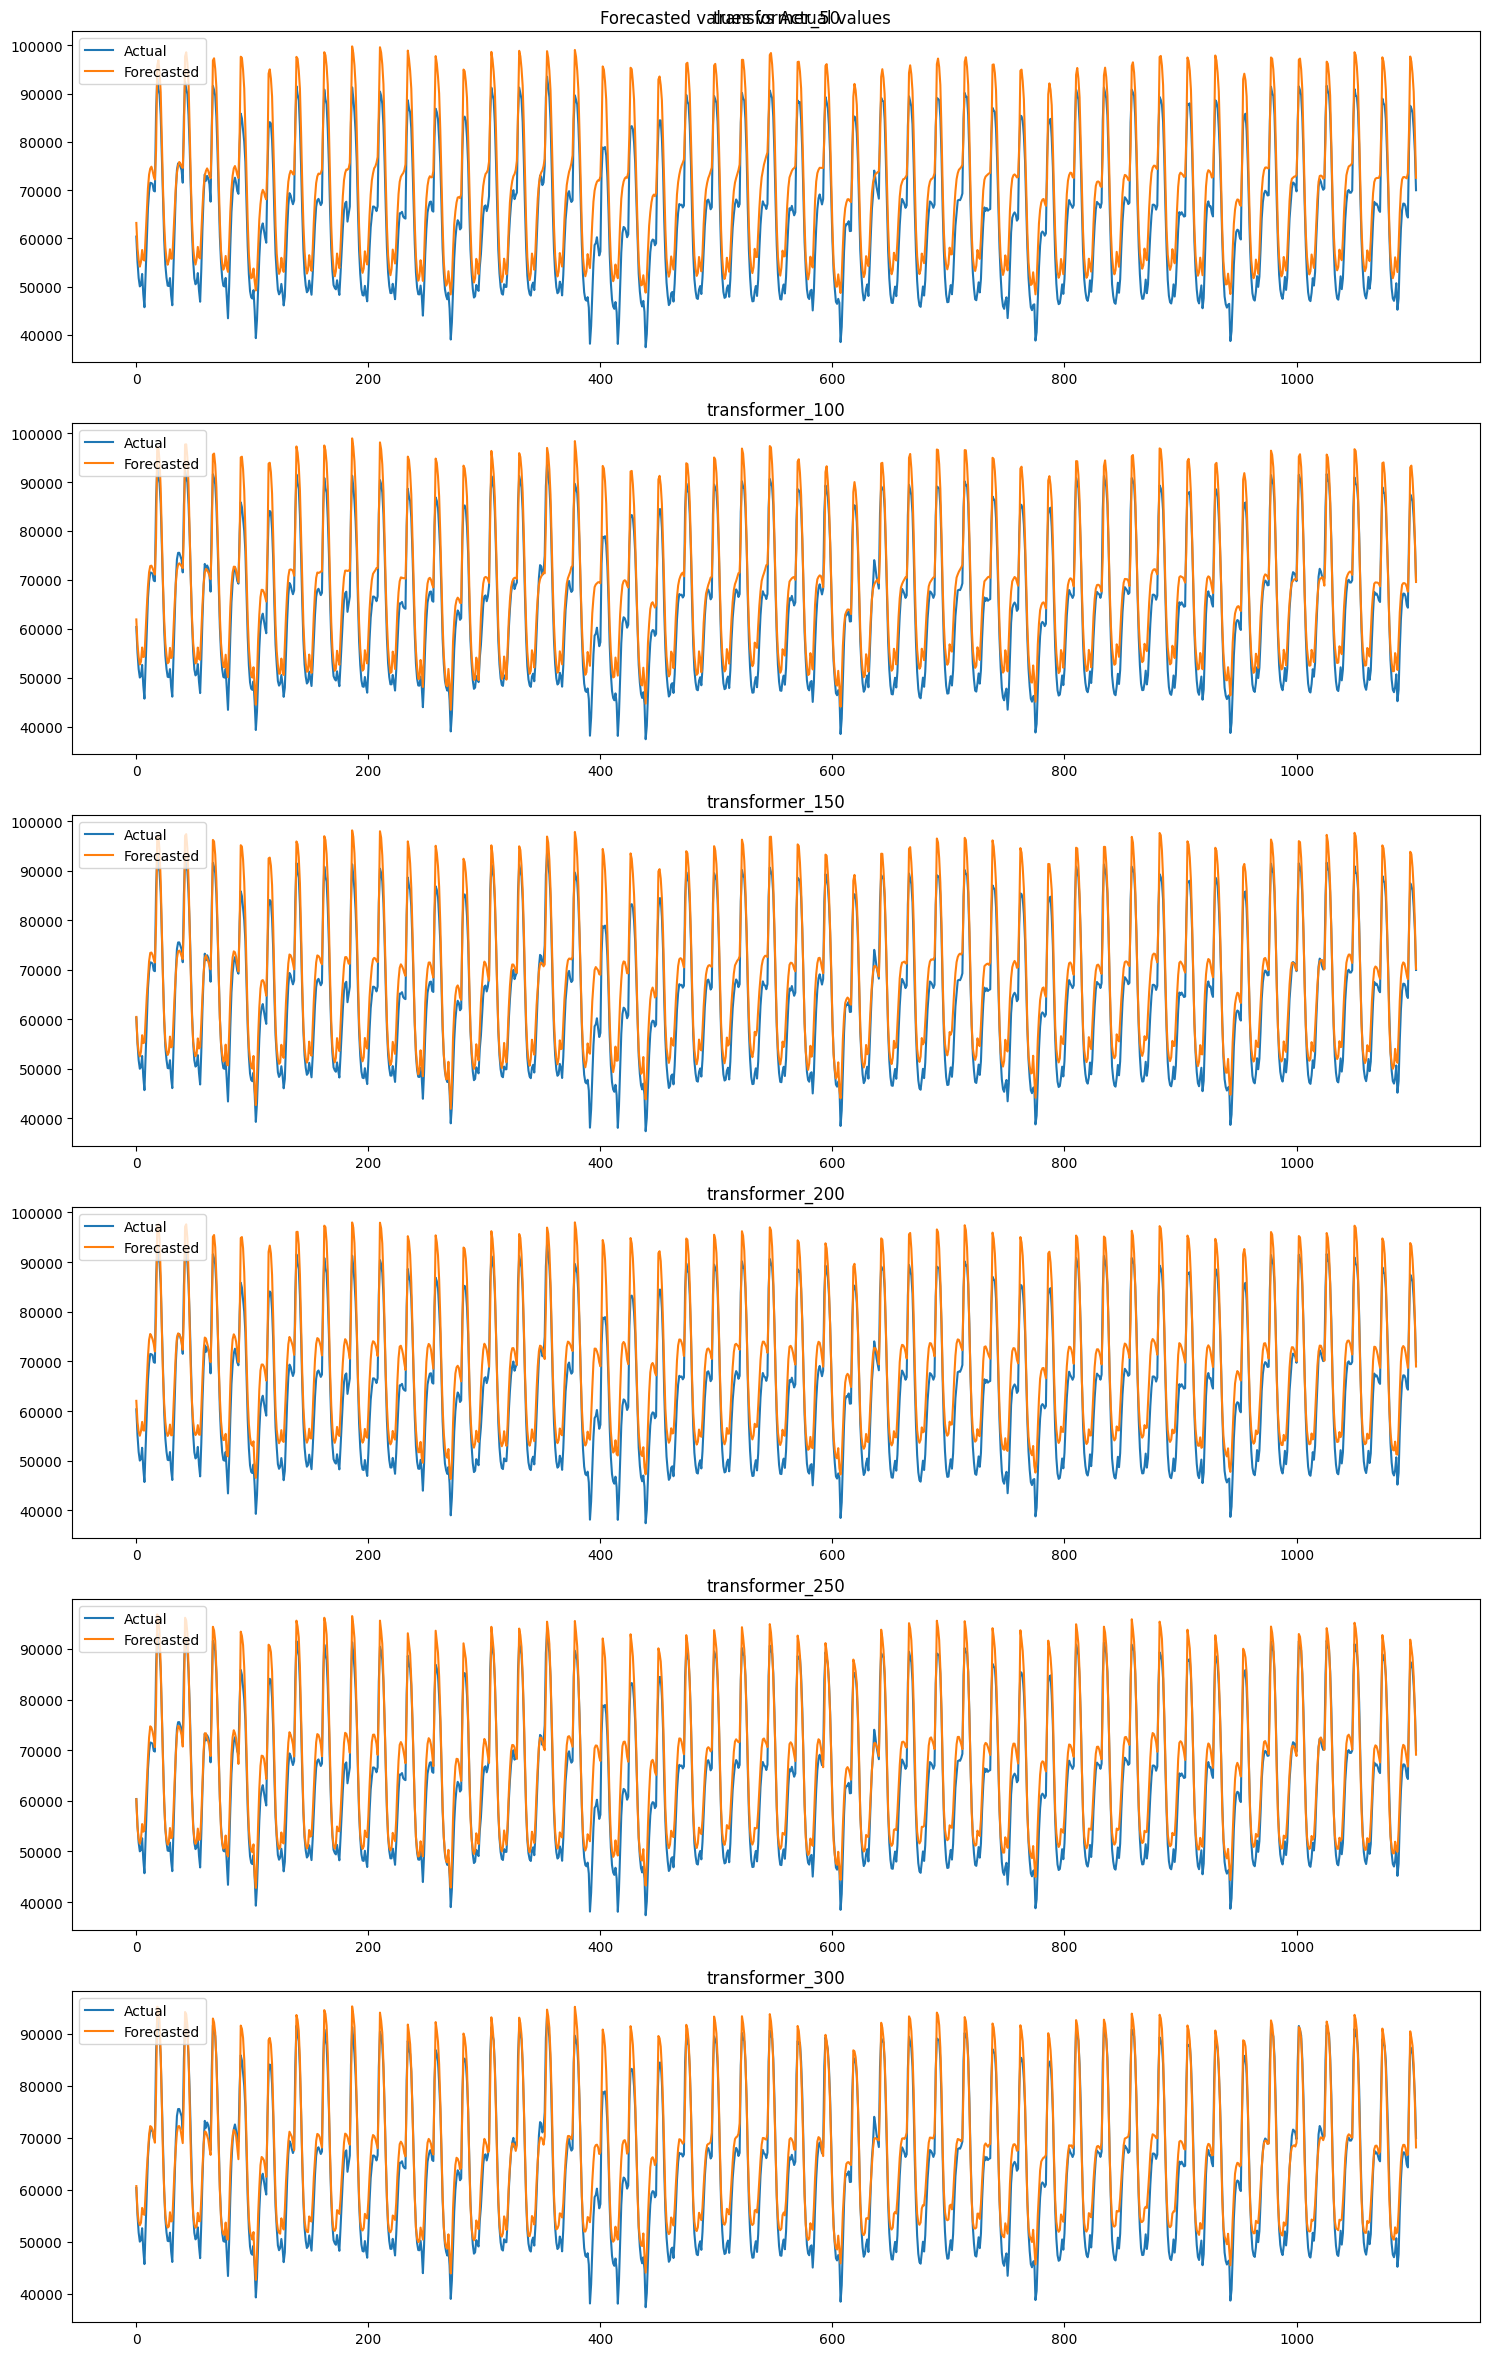

transformer_50 41432564.22328954
transformer_100 23493078.87404376
transformer_150 24346254.086269688
transformer_200 33844945.3946139
transformer_250 17104822.979067206
transformer_300 15999286.43076619


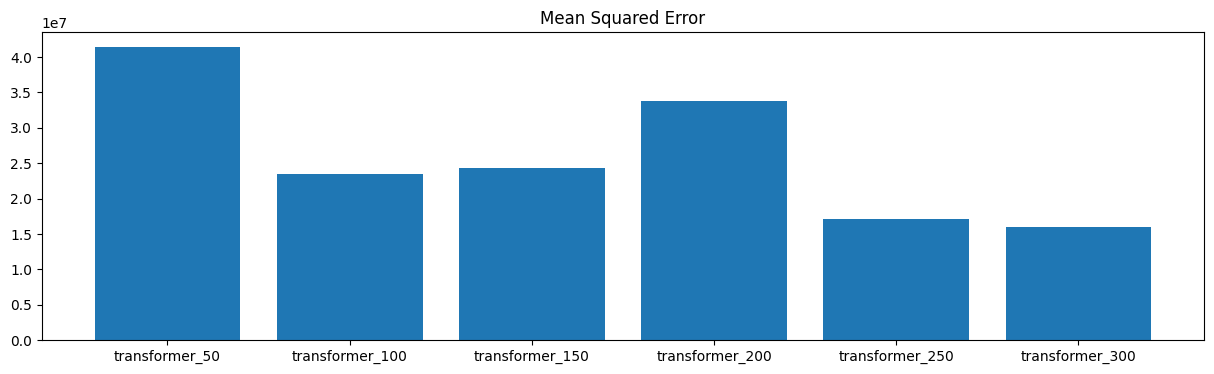

In [ ]:
# evaluate the model
model = Transformer()

evaluate_nn_mse(model, test_loader, model_state_dict_paths, device)